# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
#import
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.metrics import silhouette_score 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import time

% matplotlib inline

In [ ]:
#The below code is used to read in the transcript data, and split it into 2 smaller files so that it can be stored on github. For completeness, the code is left but is commented out.
#transcript = pd.read_json('transcript.json', orient='records', lines=True)

# Determine the halfway point to split the records
# half_records = len(transcript) // 2

# Split the DataFrame into two parts
#transcript_part1 = transcript.iloc[:half_records]
#transcript_part2 = transcript.iloc[half_records:]

# Save the first part
#transcript_part1.to_json('transcript_part1.json', orient='records', lines=True)

# Save the second part
#transcript_part2.to_json('transcript_part2.json', orient='records', lines=True)

In [2]:

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript_1 = pd.read_json('transcript_part1.json', orient='records', lines=True)
transcript_2 = pd.read_json('transcript_part2.json', orient='records', lines=True)
transcript = pd.concat([transcript_1, transcript_2], ignore_index = True )

In [3]:
#inspect portfolio df
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
#inspect profile df
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
#inpsect transcript df
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [6]:
#analyse different type of events in the transcript df
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [7]:
#analyse structure of transactions in transcript df
transcript[transcript['event'] == 'transaction'].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [8]:
#analyse struucture of offers in transcript df
transcript[transcript['event'] != 'transaction'].head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [9]:
transcript[transcript['event'] == 'offer viewed']

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
12660,offer viewed,8c7df0c393db488aac3e58b06a7ea5f9,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
12661,offer viewed,e528ceb341964128aaf58a59733ec2af,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
12662,offer viewed,262ad0fb526a4d53b572007da60cce24,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12663,offer viewed,53bac762af27471eb294ff89ca1bae2c,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [10]:
def clean_offer_id_keys(d):
    '''
    Function to clean offer_id keys in the input dictionary by renaming 'offer id' to 'offer_id'.
    
    Parameters: 
        d: dictionary, potentially with keys called 'offer id'
    Output: 
        d: dictionary, with keys cleaned by renaming 'offer id' to 'offer_id'
    '''
    if 'offer id' in d:
        d['offer_id'] = d.pop('offer id')
    
    return d

In [11]:
#clean keys in the value column in the transcript so that the 'offer id' keys are renamed 'offer_id'
transcript['value'] = transcript['value'].apply(clean_offer_id_keys)

In [12]:
transcript[transcript['event'] == 'offer viewed']

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer_id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer_id': '5a8bc65990b245e5a138643cd4eb9837'}
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'}
12660,offer viewed,8c7df0c393db488aac3e58b06a7ea5f9,0,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
12661,offer viewed,e528ceb341964128aaf58a59733ec2af,0,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
12662,offer viewed,262ad0fb526a4d53b572007da60cce24,0,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12663,offer viewed,53bac762af27471eb294ff89ca1bae2c,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [13]:
#analyse null values in profile df
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [14]:
#analyse distribution of null values
profile[profile.isna().any(axis =1)].sort_values(by='age')

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
11455,118,20180303,None,cd1f2f7d93614d5ea28f27c4875be0ff,NaN
11452,118,20160728,None,42636c607b97409ca9d284a8d13405ba,NaN
11450,118,20160206,None,5504732e8c82404095094982131076d1,NaN
11436,118,20160827,None,b356ee145ca94ee89696c218ee71eec6,NaN
11434,118,20150823,None,cd53a72ed0374e009d1a48a0aa149793,NaN
11421,118,20171013,None,dd61e2bc8cd74beaa28224af99288068,NaN
11400,118,20180303,None,f488a534b7204529908f1f95a6bd92cd,NaN
11392,118,20160312,None,8aa2f57d85934578b6a5da5682500d08,NaN
11387,118,20180121,None,6d1edf56e5894240a755df5cbfae806c,NaN


We notice that every row that contains a null value has the age of the member as 118. We can assume that this is a data quality error. As we are going to be analysing offers as well as customers, we will not handle these errors yet, but will take note and handle at a later stage.

In [15]:
#analyse null values in the portfolio df
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [16]:
#analyse null values in the transcript df
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

We note that there are no null values in the portfolio and transcript df's.

In [17]:
#Create age buckets for the age of customers

# Define the age bins and corresponding labels
bins = [0, 12, 17, 24, 34, 44, 54, 64, 99, 200]
labels = ['0-12', '13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65-100', '100+']

# Create a new column for age buckets
profile['age_bucket'] = pd.cut(profile['age'], bins=bins, labels=labels, right=False)

In [18]:
profile.head()

,age,became_member_on,gender,id,income,age_bucket
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,100+
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,55-64
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,100+
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,65-100
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,100+


In [19]:
profile.sort_values(by = 'became_member_on', ascending= False).head()

,age,became_member_on,gender,id,income,age_bucket
14757,59,20180726,M,3d50b3815c8e4f3b84f46be4d1b64cd3,34000.0,55-64
15503,77,20180726,F,e9b06d3e0b0e4aa1bf5da8d9e11dcde0,74000.0,65-100
12560,49,20180726,F,464738f7360847adb55de84c859ba8af,50000.0,45-54
10768,73,20180726,M,7ffb3bc618ad453b9bce311ec88e481d,58000.0,65-100
6524,36,20180726,M,c3ea4f8ef00d4ec99de9df2de9b4e794,33000.0,35-44


In [20]:


# Convert 'became_member_on' to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')




In [21]:
profile.sort_values(by = 'became_member_on', ascending= False).head()

,age,became_member_on,gender,id,income,age_bucket
14757,59,2018-07-26,M,3d50b3815c8e4f3b84f46be4d1b64cd3,34000.0,55-64
15503,77,2018-07-26,F,e9b06d3e0b0e4aa1bf5da8d9e11dcde0,74000.0,65-100
12560,49,2018-07-26,F,464738f7360847adb55de84c859ba8af,50000.0,45-54
10768,73,2018-07-26,M,7ffb3bc618ad453b9bce311ec88e481d,58000.0,65-100
6524,36,2018-07-26,M,c3ea4f8ef00d4ec99de9df2de9b4e794,33000.0,35-44


We note that the latest became_member_date_on is 26/7/2018, so we are going to assume that this analysis is taking place on 1/8/2018, for the purpose of calculating the length of membership. 

In [22]:

# Calculate membership duration in days
analysis_date = pd.Timestamp('2018-08-01')
profile['membership_duration'] = (analysis_date - profile['became_member_on']).dt.days

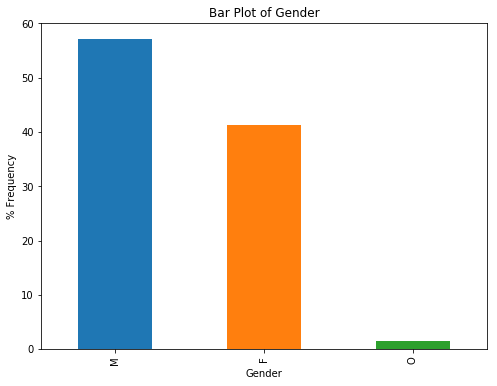

In [23]:
# Bar plot of gender distribution
(profile['gender'].value_counts(normalize = True)*100).plot(kind='bar', figsize=(8, 6))
plt.title('Bar Plot of Gender')
plt.xlabel('Gender')
plt.ylabel('% Frequency')
plt.show()

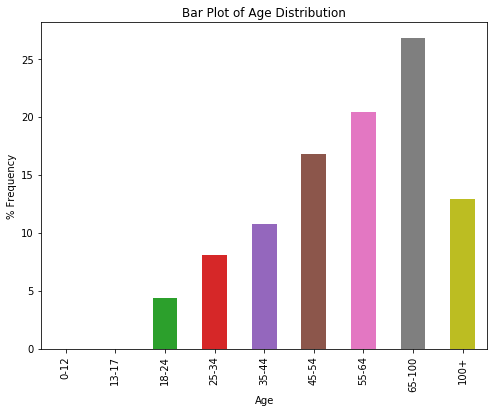

In [24]:
# Define the custom order for the age buckets
custom_order = ['0-12', '13-17', '18-24', '25-34', '35-44','45-54','55-64', '65-100', '100+']

profile['age_bucket'] = pd.Categorical(profile['age_bucket'], categories=custom_order, ordered=True)
# Bar plot of age distribution
(profile['age_bucket'].value_counts(normalize = True).loc[custom_order]*100).plot(kind='bar', figsize=(8, 6))
plt.title('Bar Plot of Age Distribution')
plt.xlabel('Age')
plt.ylabel('% Frequency')
plt.show()

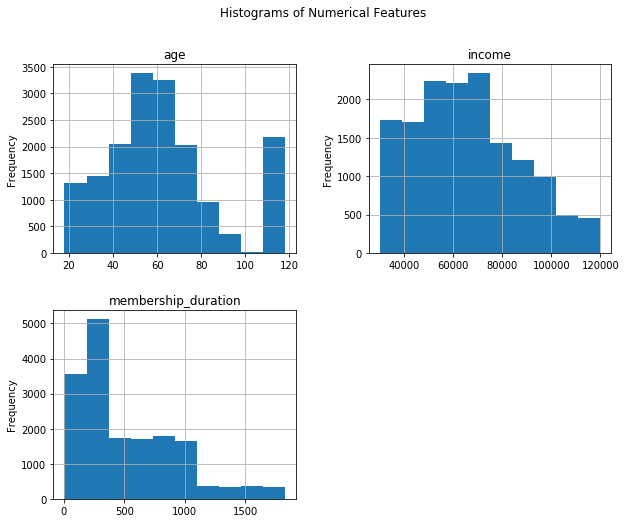

In [25]:
# Histograms
axes = profile.hist(figsize=(10, 8), bins=10)
plt.suptitle('Histograms of Numerical Features')
# Set y-axis title for each histogram
for ax in axes.flatten():
    ax.set_ylabel('Frequency')

plt.show()

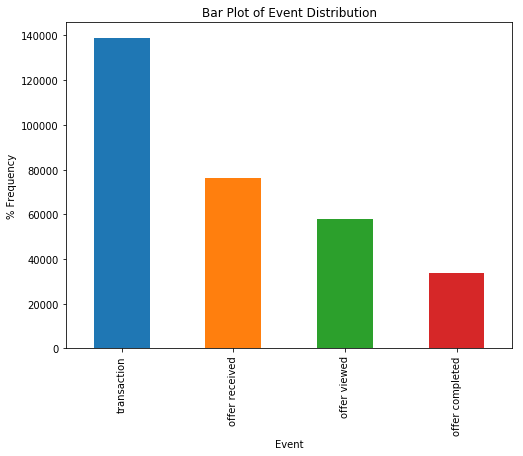

In [26]:
# Bar plot of transcript distribution
transcript['event'].value_counts().plot(kind='bar', figsize=(8, 6))
plt.title('Bar Plot of Event Distribution')
plt.xlabel('Event')
plt.ylabel('% Frequency')
plt.show()

In [27]:
number_of_offers_received =transcript[transcript['event'] == 'offer received']['event'].count()
number_of_offers_viewed = transcript[transcript['event'] == 'offer viewed']['event'].count()
number_of_offers_completed = transcript[transcript['event'] == 'offer completed']['event'].count()

In [28]:
# Calculate the percentages
percentage_viewed = (number_of_offers_viewed / number_of_offers_received) * 100
percentage_completed = (number_of_offers_completed / number_of_offers_received) * 100

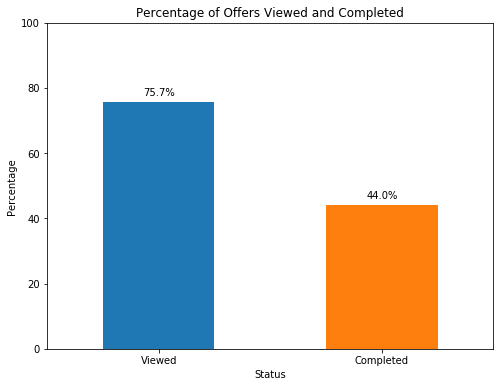

In [29]:
percentages = pd.DataFrame({
    'Status': ['Viewed', 'Completed'],
    'Percentage': [percentage_viewed, percentage_completed]
})

# Plot the data using a bar plot
ax = percentages.plot(kind='bar', x='Status', y='Percentage', legend=False, figsize=(8, 6))
plt.title('Percentage of Offers Viewed and Completed')
plt.xlabel('Status')
plt.ylabel('Percentage')
# Annotate the values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.ylim(0, 100)  # Ensure y-axis ranges from 0 to 100 for percentage
plt.xticks(rotation=0)
plt.show()

In [30]:
# Expand 'value' dictionary into separate columns
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id') if 'offer_id' in x else None)
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount') if 'amount' in x else 0)
transcript.drop(columns=['value'], inplace=True)

In [31]:
transcript.head()

,event,person,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


In [32]:
#check that each offer has a valid offer_id (i.e. only transactions have a null offer_id)
transcript[transcript['offer_id'].isna()]['event'].unique()

array(['transaction'], dtype=object)

In [33]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


## Data Modelling

In [34]:
#join the offer data (from portfolio) to the transcript data to give information about the offers
offers = pd.merge(transcript, portfolio, how = 'left', left_on = 'offer_id', right_on = 'id')

In [35]:
offers.head()

,event,person,time,offer_id,amount,channels,difficulty,duration,id,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,"[web, email]",20.0,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,"[web, email, mobile]",10.0,7.0,2906b810c7d4411798c6938adc9daaa5,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,"[web, email, mobile, social]",10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,"[web, email, mobile, social]",10.0,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10.0


In [36]:
profile.head()

,age,became_member_on,gender,id,income,age_bucket,membership_duration
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,100+,535
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,55-64,382
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,100+,20
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,65-100,449
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,100+,362


In [37]:
#merge the profile data onto the offers data, to give customer information to each offer and transaction
offers_persons = pd.merge(offers, profile, how = 'left', left_on = 'person', right_on='id' )

In [38]:
offers_persons.columns

Index(['event', 'person', 'time', 'offer_id', 'amount', 'channels',
       'difficulty', 'duration', 'id_x', 'offer_type', 'reward', 'age',
       'became_member_on', 'gender', 'id_y', 'income', 'age_bucket',
       'membership_duration'],
      dtype='object')

In [39]:
# Define a function to count events by offer type
def count_events_by_type(event_df, event_name):
    '''
    Function to count number of events by offer type.
    
    Parameters: 
        event_df: dataframe containing events and a offer_type column
        event_name: name of event to be counted
    Output: 
        event_counts: dataframe, containing a count of events by offer_type
    '''
    event_counts = event_df.groupby(['person', 'offer_type']).size().unstack(fill_value=0)
    event_counts.columns = [f'num_of_{offer_type}_offers_{event_name}' for offer_type in event_counts.columns]
    return event_counts

# Filter events for offers received, viewed, and completed
received = offers_persons[offers_persons['event'] == 'offer received']
viewed = offers_persons[offers_persons['event'] == 'offer viewed']
completed = offers_persons[offers_persons['event'] == 'offer completed']

# Count events
received_counts = count_events_by_type(received, 'received')
viewed_counts = count_events_by_type(viewed, 'viewed')
completed_counts = count_events_by_type(completed, 'completed')


In [40]:

# Combine counts of each offer type into a single DataFrame
summary_df = pd.merge(received_counts, viewed_counts, how = 'outer', on = 'person')
summary_df = pd.merge(summary_df, completed_counts, how = 'outer', on = 'person').fillna(0)

In [41]:
summary_df.head()

,num_of_bogo_offers_received,num_of_discount_offers_received,num_of_informational_offers_received,num_of_bogo_offers_viewed,num_of_discount_offers_viewed,num_of_informational_offers_viewed,num_of_bogo_offers_completed,num_of_discount_offers_completed
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,1,2,2,1.0,1.0,2.0,1.0,2.0
00116118485d4dfda04fdbaba9a87b5c,2,0,0,2.0,0.0,0.0,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,1,2,2,1.0,2.0,2.0,1.0,2.0
0020c2b971eb4e9188eac86d93036a77,2,2,1,1.0,1.0,1.0,1.0,2.0
0020ccbbb6d84e358d3414a3ff76cffd,2,1,1,2.0,1.0,1.0,2.0,1.0


In [42]:
#calculate total number of offers received, viewed and completed
summary_df['num_of_offers_received'] = summary_df['num_of_bogo_offers_received'] + summary_df['num_of_discount_offers_received'] + summary_df['num_of_informational_offers_received']
summary_df['num_of_offers_viewed'] = summary_df['num_of_bogo_offers_viewed'] + summary_df['num_of_discount_offers_viewed'] + summary_df['num_of_informational_offers_viewed']
summary_df['num_of_offers_completed'] = summary_df['num_of_bogo_offers_completed'] + summary_df['num_of_discount_offers_completed']

In [43]:
summary_df = summary_df.reset_index()

In [44]:
transcript.head()

,event,person,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


In [45]:
# Aggregate transaction data (total amount spent, number of transactions, last transcation time)
transaction_data = transcript[transcript['event'] == 'transaction'].groupby('person').agg({
    'amount': 'sum',
    'time': 'max',
    'person': 'count'
}).rename(columns={'amount': 'total_spent', 'time': 'last_transaction', 'person': 'num_of_transactions'})


In [46]:
transaction_data.head()

,total_spent,last_transaction,num_of_transactions
person,,,
0009655768c64bdeb2e877511632db8f,127.60,696,8
00116118485d4dfda04fdbaba9a87b5c,4.09,474,3
0011e0d4e6b944f998e987f904e8c1e5,79.46,654,5
0020c2b971eb4e9188eac86d93036a77,196.86,708,8
0020ccbbb6d84e358d3414a3ff76cffd,154.05,672,12


In [47]:
#analyse null values in transaction_data
transaction_data.isna().sum()

total_spent            0
last_transaction       0
num_of_transactions    0
dtype: int64

In [48]:
transaction_data = transaction_data.reset_index()

In [49]:

#transcript_offer = pd.merge(transcript, portfolio, how = 'left', left_on = 'offer_id', right_on = 'id')

In [50]:
#transcript_offer

In [51]:

# Merge aggregated transaction data with summary_df (number of offers viewed, received and completed) for each customer
customer_data = pd.merge(summary_df, transaction_data, on='person', how='left').fillna(0)


In [52]:
#customer_transaction_offer_data shows a summary of the offers and transactions for each customer. We need to include a breakdown of which of the offers were 'successful', i.e. completed and viewed, which offers were 'detrimental', i.e. completed but not viewed, and which had 'no impact'

#merge the customer_data df with the profile df, to get the information about each customer
customer_transaction_offer_data = pd.merge(customer_data, profile, left_on = 'person', right_on= 'id', how = 'left')

We note at this stage that the customer_transaction_offer_data shows a summary of the offers and transactions for each customer. 

We need to include a breakdown of which of the offers were 'successful', i.e. completed and viewed, which offers were 'detrimental', i.e. completed but not viewed, and which had 'no impact'



In [53]:
customer_transaction_offer_data.head(10)

,person,num_of_bogo_offers_received,num_of_discount_offers_received,num_of_informational_offers_received,num_of_bogo_offers_viewed,num_of_discount_offers_viewed,num_of_informational_offers_viewed,num_of_bogo_offers_completed,num_of_discount_offers_completed,num_of_offers_received,...,total_spent,last_transaction,num_of_transactions,age,became_member_on,gender,id,income,age_bucket,membership_duration
0,0009655768c64bdeb2e877511632db8f,1,2,2,1.0,1.0,2.0,1.0,2.0,5,...,127.60,696.0,8.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,25-34,467
1,00116118485d4dfda04fdbaba9a87b5c,2,0,0,2.0,0.0,0.0,0.0,0.0,2,...,4.09,474.0,3.0,118,2018-04-25,None,00116118485d4dfda04fdbaba9a87b5c,NaN,100+,98
2,0011e0d4e6b944f998e987f904e8c1e5,1,2,2,1.0,2.0,2.0,1.0,2.0,5,...,79.46,654.0,5.0,40,2018-01-09,O,0011e0d4e6b944f998e987f904e8c1e5,57000.0,35-44,204
3,0020c2b971eb4e9188eac86d93036a77,2,2,1,1.0,1.0,1.0,1.0,2.0,5,...,196.86,708.0,8.0,59,2016-03-04,F,0020c2b971eb4e9188eac86d93036a77,90000.0,55-64,880
4,0020ccbbb6d84e358d3414a3ff76cffd,2,1,1,2.0,1.0,1.0,2.0,1.0,4,...,154.05,672.0,12.0,24,2016-11-11,F,0020ccbbb6d84e358d3414a3ff76cffd,60000.0,25-34,628
5,003d66b6608740288d6cc97a6903f4f0,0,3,2,0.0,2.0,2.0,0.0,3.0,5,...,48.34,696.0,18.0,26,2017-06-21,F,003d66b6608740288d6cc97a6903f4f0,73000.0,25-34,406
6,00426fe3ffde4c6b9cb9ad6d077a13ea,0,4,1,0.0,1.0,1.0,0.0,1.0,5,...,68.51,696.0,17.0,19,2016-08-09,F,00426fe3ffde4c6b9cb9ad6d077a13ea,65000.0,18-24,722
7,004b041fbfe44859945daa2c7f79ee64,1,1,1,1.0,1.0,0.0,1.0,1.0,3,...,138.36,714.0,6.0,55,2018-05-08,F,004b041fbfe44859945daa2c7f79ee64,74000.0,55-64,85
8,004c5799adbf42868b9cff0396190900,3,2,0,2.0,2.0,0.0,3.0,2.0,5,...,347.38,690.0,12.0,54,2016-03-31,M,004c5799adbf42868b9cff0396190900,99000.0,55-64,853
9,005500a7188546ff8a767329a2f7c76a,4,1,0,3.0,0.0,0.0,1.0,0.0,5,...,20.36,588.0,4.0,56,2017-12-09,M,005500a7188546ff8a767329a2f7c76a,47000.0,55-64,235


In [54]:
#create a df that just contains the offers
offers = transcript[transcript['event'].isin(['offer received', 'offer viewed', 'offer completed'])]

In [55]:
#create an offer index, which is the index for a person receiving the same offer multiple times
offers['offer_idx'] = offers.groupby(['person', 'offer_id', 'event']).cumcount() + 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [56]:
offers.head()

,event,person,time,offer_id,amount,offer_idx
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,1
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,1
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,1
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,1


In [57]:
#pivot the offers table to indicate whether each offer has been completed, received and viewed
offers_pivot = offers.pivot_table(index=['offer_id', 'person', 'offer_idx'], columns='event', aggfunc='size', fill_value=0).reset_index()

In [58]:
offers_pivot.head()

event,offer_id,person,offer_idx,offer completed,offer received,offer viewed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,1,1,1,1
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,1,1,1,0
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,1,0,1,0
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,1,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,0063def0f9c14bc4805322a488839b32,1,0,1,1


In [59]:
#check that each offer has been received, viweed and completed at most once 
print(f"Unique values for offer received are: {offers_pivot['offer received'].unique() } ")
print(f"Unique values for offer viewed are: {offers_pivot['offer viewed'].unique()}")
print(f"Unique values for offer completed are: {offers_pivot['offer completed'].unique()}")

Unique values for offer received are: [1] 
Unique values for offer viewed are: [1 0]
Unique values for offer completed are: [1 0]


In [60]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [61]:
#merge the offers_pivot table with the data about each offer (porfolio)
offers_pivot = pd.merge(offers_pivot, portfolio, left_on = 'offer_id', right_on = 'id', how = 'left')

In [62]:
#set the rule for an offer to be successful as where the offer is completed and viewed (i.e. if a customer completes an offer but hasn't viewed it then it isn't successful)
offers_pivot['successful offer'] = offers_pivot.apply(lambda row: 1 if row['offer completed'] == 1 and row['offer viewed'] == 1 else 0, axis = 1)

In [63]:
offers_pivot.head()

,offer_id,person,offer_idx,offer completed,offer received,offer viewed,channels,difficulty,duration,id,offer_type,reward,successful offer
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,1,1,1,1,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,1,1,1,0,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,1,0,1,0,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,1,1,1,0,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,0063def0f9c14bc4805322a488839b32,1,0,1,1,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0


In [64]:
offers_pivot[offers_pivot['offer_type'] == 'informational'].head()

,offer_id,person,offer_idx,offer completed,offer received,offer viewed,channels,difficulty,duration,id,offer_type,reward,successful offer
22946,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,1,0,1,1,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0
22947,3f207df678b143eea3cee63160fa8bed,0011e0d4e6b944f998e987f904e8c1e5,1,0,1,1,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0
22948,3f207df678b143eea3cee63160fa8bed,003d66b6608740288d6cc97a6903f4f0,1,0,1,1,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0
22949,3f207df678b143eea3cee63160fa8bed,004b041fbfe44859945daa2c7f79ee64,1,0,1,0,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0
22950,3f207df678b143eea3cee63160fa8bed,0056df74b63b4298809f0b375a304cf4,1,0,1,1,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0


We note that this definition of success is not sufficient for informational offers as they are never 'completed'. As such we will need to devise a new method of defining success for informational offers.

We will consider an informational offer to be successful if the customer makes a transaction within the duration of viewing the informational offer.

In [65]:
#create a df of just the viewed offers
offers_viewed = offers[offers['event'] =='offer viewed'][['person','time','offer_id', 'offer_idx']]

In [66]:
offers_viewed.head()

,person,time,offer_id,offer_idx
12650,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,1
12651,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837,1
12652,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1
12653,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd,1
12655,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837,1


In [67]:
#merge the offer viewed data onto the offers data to indicated the time at which each offer was viewed (if it was viewed)
offers_pivot_1 = pd.merge(offers_pivot, offers_viewed, how = 'left', on = ['person', 'offer_id', 'offer_idx']).rename(columns = {'time': 'time viewed'})

In [68]:
offers_pivot_1.head()

,offer_id,person,offer_idx,offer completed,offer received,offer viewed,channels,difficulty,duration,id,offer_type,reward,successful offer,time viewed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,1,1,1,1,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,432.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,1,1,1,0,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,NaN
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,1,0,1,0,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,NaN
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,1,1,1,0,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,NaN
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,0063def0f9c14bc4805322a488839b32,1,0,1,1,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,576.0


In [69]:
#create a df of just the transactions
transactions = transcript[transcript['event'] == 'transaction'].sort_values(by = ['person', 'time'])

In [70]:
transactions.head(10)

,event,person,time,offer_id,amount
89291,transaction,0009655768c64bdeb2e877511632db8f,228,None,22.16
168412,transaction,0009655768c64bdeb2e877511632db8f,414,None,8.57
228422,transaction,0009655768c64bdeb2e877511632db8f,528,None,14.11
237784,transaction,0009655768c64bdeb2e877511632db8f,552,None,13.56
258883,transaction,0009655768c64bdeb2e877511632db8f,576,None,10.27
293497,transaction,0009655768c64bdeb2e877511632db8f,660,None,12.36
300930,transaction,0009655768c64bdeb2e877511632db8f,690,None,28.16
302205,transaction,0009655768c64bdeb2e877511632db8f,696,None,18.41
104088,transaction,00116118485d4dfda04fdbaba9a87b5c,294,None,0.70
187632,transaction,00116118485d4dfda04fdbaba9a87b5c,456,None,0.20


In [71]:
#offers_viewed = offers[offers['event'] == 'offer viewed']

In [72]:
#offers_viewed

In [73]:
#create a duplicate column of the transaction time
transactions['transaction time'] = transactions['time']

In [74]:
#merge the offer data with the transaction data such that for each person
# the time of the transaction that comes after the offer was viewed
# is taken. 
offers_viewed_time = pd.merge_asof(
    left = offers_viewed.sort_values(by = ['time']),
    right = transactions.sort_values(by = ['time']),
    by='person',
    on = 'time',
    direction='forward'
)


In [75]:
#remove unnecessary columns
offers_viewed_time = offers_viewed_time[['person', 'offer_idx','offer_id_x', 'transaction time']].rename(columns = {'offer_id_x': 'offer_id'})

In [76]:
offers_viewed_time.head()

,person,offer_idx,offer_id,transaction time
0,389bc3fa690240e798340f5a15918d5c,1,f19421c1d4aa40978ebb69ca19b0e20d,60.0
1,bf5783772fee4f2ab126f07bf3be80f1,1,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0
2,14cbeafc2297453e9bf4924c2eabe35e,1,fafdcd668e3743c1bb461111dcafc2a4,12.0
3,324cde983eef4759ace1e2e30816b751,1,2298d6c36e964ae4a3e7e9706d1fb8c2,222.0
4,79e3b16de4964b6c82e45e0014a42502,1,5a8bc65990b245e5a138643cd4eb9837,60.0


In [77]:
offers_pivot_1.head()

,offer_id,person,offer_idx,offer completed,offer received,offer viewed,channels,difficulty,duration,id,offer_type,reward,successful offer,time viewed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,1,1,1,1,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,432.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,1,1,1,0,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,NaN
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,1,0,1,0,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,NaN
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,1,1,1,0,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,NaN
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,0063def0f9c14bc4805322a488839b32,1,0,1,1,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,576.0


In [78]:
#merge the offer_pivot_1 data with the data that contains the time each offer was viewed and when the next transaciton was
offers_pivot_2 = pd.merge(offers_pivot_1, offers_viewed_time, left_on = ['person', 'offer_idx', 'offer_id'], right_on= ['person', 'offer_idx', 'offer_id'], how = 'left')

In [79]:
offers_pivot_2.head()

,offer_id,person,offer_idx,offer completed,offer received,offer viewed,channels,difficulty,duration,id,offer_type,reward,successful offer,time viewed,transaction time
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,1,1,1,1,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,432.0,576.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,1,1,1,0,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,NaN,NaN
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,1,0,1,0,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,NaN,NaN
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,1,1,1,0,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,NaN,NaN
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,0063def0f9c14bc4805322a488839b32,1,0,1,1,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,576.0,NaN


In [80]:
#calculate whether the next transaction was within the duraction of the offer
offers_pivot_2['transaction within duration of offer'] = offers_pivot_2.apply(lambda row: 1 if row['transaction time'] - row['time viewed'] < row['duration'] * 24 else 0, axis = 1)

In [81]:
#calculate whether an offer was successful, where we use different criteria
# for informational offers, and use the criteria from above for other offer types
offers_pivot_2['successful offer'] = offers_pivot_2.apply(lambda row: row['successful offer'] if row['offer_type'] != 'informational' else (1 if row['transaction within duration of offer'] == 1 else 0), axis = 1)

In [82]:
#analyse the informational offers
offers_pivot_2[offers_pivot_2['offer_type'] =='informational']

,offer_id,person,offer_idx,offer completed,offer received,offer viewed,channels,difficulty,duration,id,offer_type,reward,successful offer,time viewed,transaction time,transaction within duration of offer
22946,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,1,0,1,1,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,372.0,414.0,1
22947,3f207df678b143eea3cee63160fa8bed,0011e0d4e6b944f998e987f904e8c1e5,1,0,1,1,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,6.0,132.0,0
22948,3f207df678b143eea3cee63160fa8bed,003d66b6608740288d6cc97a6903f4f0,1,0,1,1,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,372.0,384.0,1
22949,3f207df678b143eea3cee63160fa8bed,004b041fbfe44859945daa2c7f79ee64,1,0,1,0,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,NaN,NaN,0
22950,3f207df678b143eea3cee63160fa8bed,0056df74b63b4298809f0b375a304cf4,1,0,1,1,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,528.0,558.0,1
22951,3f207df678b143eea3cee63160fa8bed,0069a50874d846438e58acff5e594725,1,0,1,0,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,NaN,NaN,0
22952,3f207df678b143eea3cee63160fa8bed,00715b6e55c3431cb56ff7307eb19675,1,0,1,0,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,NaN,NaN,0
22953,3f207df678b143eea3cee63160fa8bed,0082fd87c18f45f2be70dbcbb0fb8aad,1,0,1,1,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,168.0,252.0,1
22954,3f207df678b143eea3cee63160fa8bed,0082fd87c18f45f2be70dbcbb0fb8aad,2,0,1,1,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,636.0,696.0,1
22955,3f207df678b143eea3cee63160fa8bed,00840a2ca5d2408e982d56544dc14ffd,1,0,1,0,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,NaN,NaN,0


In [83]:
#remove unneccessary columns
offers_pivot_3 = offers_pivot_2[['offer_id','person', 'offer_idx','offer completed','offer received', 'offer viewed', 'channels', 'difficulty', 'duration', 'offer_type', 'reward','successful offer']]

In [84]:
#merge the data with the customer profile data so each offer has information about the customers
offers_pivot_4 = pd.merge(offers_pivot_3, profile, how = 'left', left_on = 'person', right_on = 'id')

In [85]:
offers_pivot_4.head()

,offer_id,person,offer_idx,offer completed,offer received,offer viewed,channels,difficulty,duration,offer_type,reward,successful offer,age,became_member_on,gender,id,income,age_bucket,membership_duration
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,1,1,1,1,"[web, email]",20,10,discount,5,1,40,2018-01-09,O,0011e0d4e6b944f998e987f904e8c1e5,57000.0,35-44,204
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,1,1,1,0,"[web, email]",20,10,discount,5,0,26,2017-06-21,F,003d66b6608740288d6cc97a6903f4f0,73000.0,25-34,406
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,1,0,1,0,"[web, email]",20,10,discount,5,0,19,2016-08-09,F,00426fe3ffde4c6b9cb9ad6d077a13ea,65000.0,18-24,722
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,1,1,1,0,"[web, email]",20,10,discount,5,0,54,2016-08-21,M,0056df74b63b4298809f0b375a304cf4,91000.0,55-64,710
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,0063def0f9c14bc4805322a488839b32,1,0,1,1,"[web, email]",20,10,discount,5,0,118,2018-06-15,None,0063def0f9c14bc4805322a488839b32,NaN,100+,47


In [86]:
customer_transaction_offer_data.head()

,person,num_of_bogo_offers_received,num_of_discount_offers_received,num_of_informational_offers_received,num_of_bogo_offers_viewed,num_of_discount_offers_viewed,num_of_informational_offers_viewed,num_of_bogo_offers_completed,num_of_discount_offers_completed,num_of_offers_received,...,total_spent,last_transaction,num_of_transactions,age,became_member_on,gender,id,income,age_bucket,membership_duration
0,0009655768c64bdeb2e877511632db8f,1,2,2,1.0,1.0,2.0,1.0,2.0,5,...,127.60,696.0,8.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,25-34,467
1,00116118485d4dfda04fdbaba9a87b5c,2,0,0,2.0,0.0,0.0,0.0,0.0,2,...,4.09,474.0,3.0,118,2018-04-25,None,00116118485d4dfda04fdbaba9a87b5c,NaN,100+,98
2,0011e0d4e6b944f998e987f904e8c1e5,1,2,2,1.0,2.0,2.0,1.0,2.0,5,...,79.46,654.0,5.0,40,2018-01-09,O,0011e0d4e6b944f998e987f904e8c1e5,57000.0,35-44,204
3,0020c2b971eb4e9188eac86d93036a77,2,2,1,1.0,1.0,1.0,1.0,2.0,5,...,196.86,708.0,8.0,59,2016-03-04,F,0020c2b971eb4e9188eac86d93036a77,90000.0,55-64,880
4,0020ccbbb6d84e358d3414a3ff76cffd,2,1,1,2.0,1.0,1.0,2.0,1.0,4,...,154.05,672.0,12.0,24,2016-11-11,F,0020ccbbb6d84e358d3414a3ff76cffd,60000.0,25-34,628


In [87]:
#Add a column to count successful events by customer, using the methods defined earlier. 

# Filter events for offers successful
successful = offers_pivot_4[offers_pivot_4['successful offer'] == 1]

# Count events
successful_counts = count_events_by_type(successful, 'successful')


In [88]:
#merge the customer tranaction data with the successful events count
customer_transaction_offer_data_2 = pd.merge(customer_transaction_offer_data, successful_counts, how = 'left', on = 'person')

In [89]:
#fill null values as 0 for the successful counts
customer_transaction_offer_data_2[
    ['num_of_bogo_offers_successful'
     ,'num_of_discount_offers_successful'
    , 'num_of_informational_offers_successful']] = customer_transaction_offer_data_2[
    ['num_of_bogo_offers_successful'
     ,'num_of_discount_offers_successful'
    , 'num_of_informational_offers_successful']].fillna(0)

In [90]:
#calcualte total num of successful offers
customer_transaction_offer_data_2['num_of_successful_offers'] = (customer_transaction_offer_data_2['num_of_bogo_offers_successful']
    + customer_transaction_offer_data_2['num_of_discount_offers_successful']
    + customer_transaction_offer_data_2['num_of_informational_offers_successful'])

In [91]:
customer_transaction_offer_data_2.columns

Index(['person', 'num_of_bogo_offers_received',
       'num_of_discount_offers_received',
       'num_of_informational_offers_received', 'num_of_bogo_offers_viewed',
       'num_of_discount_offers_viewed', 'num_of_informational_offers_viewed',
       'num_of_bogo_offers_completed', 'num_of_discount_offers_completed',
       'num_of_offers_received', 'num_of_offers_viewed',
       'num_of_offers_completed', 'total_spent', 'last_transaction',
       'num_of_transactions', 'age', 'became_member_on', 'gender', 'id',
       'income', 'age_bucket', 'membership_duration',
       'num_of_bogo_offers_successful', 'num_of_discount_offers_successful',
       'num_of_informational_offers_successful', 'num_of_successful_offers'],
      dtype='object')

In [92]:
customer_transaction_offer_data_2[['person','num_of_offers_received', 'num_of_offers_received', 'num_of_successful_offers']].head(10)

,person,num_of_offers_received,num_of_offers_received,num_of_successful_offers
0,0009655768c64bdeb2e877511632db8f,5,5,4.0
1,00116118485d4dfda04fdbaba9a87b5c,2,2,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,5,5,3.0
3,0020c2b971eb4e9188eac86d93036a77,5,5,3.0
4,0020ccbbb6d84e358d3414a3ff76cffd,4,4,4.0
5,003d66b6608740288d6cc97a6903f4f0,5,5,4.0
6,00426fe3ffde4c6b9cb9ad6d077a13ea,5,5,2.0
7,004b041fbfe44859945daa2c7f79ee64,3,3,2.0
8,004c5799adbf42868b9cff0396190900,5,5,4.0
9,005500a7188546ff8a767329a2f7c76a,5,5,0.0


We now deal with the customers that have dq issues, which are identified by the customers having an age of 118.

In [93]:
#calculate number of offers for customers of age = 118 (i.e. where data quality issues exists)
num_of_offers_118_yr_olds = customer_transaction_offer_data_2[customer_transaction_offer_data_2['age'] == 118]['num_of_offers_received'].sum() 

In [94]:
#calculate total number of offers
num_of_total_offers = customer_transaction_offer_data_2['num_of_offers_received'].sum()

In [95]:
(num_of_offers_118_yr_olds/num_of_total_offers)*100

print(f"{round((num_of_offers_118_yr_olds/num_of_total_offers)*100, 2)} % of total offers are sent out to customers that hvae an age of 118.")

12.82 % of total offers are sent out to customers that hvae an age of 118.


12.8% of the offers that were sent out were to customers that have an age of 118, and appear to be where there are data quality issues for the customers data. As the analysis we are completing is reliant on information about the customer, we are going to remove this data from analysis. 

As a result of this, one finding we could provide to Starbucks is to understand how their customers respond to offers better (and other customer behavioural data) we would recommend improving data quality issues at source so that we are able to analyse how these customers respond to different initiatives. 

In [96]:
#remove offers that were given to customers with dq issues (i.e. age = 118)
customer_transaction_offer_data_2 = customer_transaction_offer_data_2[customer_transaction_offer_data_2['age'] != 118]

In [97]:
#inspect the other customers that have an age > 100. 
customer_transaction_offer_data_2[customer_transaction_offer_data_2['age_bucket'] == '100+'][['age', 'person', 'gender','income','age_bucket']]

,age,person,gender,income,age_bucket
282,101,047ad0135cfe4c0ea5ba019da4de9c52,F,59000.0,100+
1408,101,1593d617fac246ef8e50dbb0ffd77f5f,F,82000.0,100+
2345,100,24c1287eb7a84cfd80472a82e05b1d57,F,63000.0,100+
2599,100,28bbebb2b76f4057b1115dd80441e37a,F,118000.0,100+
3927,100,3b34370727654cfca5322bca2aba9ffd,F,96000.0,100+
4038,99,3caceb24b79847aeaa0dfceb69d5fb2c,F,74000.0,100+
5134,101,4d2ccfcbbebf4bd9baf4b7e433d0e288,F,43000.0,100+
5834,99,57accabdb8df429d983a7ac0ddd50892,F,85000.0,100+
8874,100,857fc6e18cf74f7b8ebce26bbfbd3028,F,109000.0,100+
8903,100,85f4e5ea5c0044619482bfe16ae32c01,F,71000.0,100+


In [98]:
#also remove the offers where customer has an age of 118 from the offers_pivot table
offers_pivot_4 = offers_pivot_4[offers_pivot_4['age'] != 118]

In [99]:
#calculate number of unsuccessful offers
customer_transaction_offer_data_2['num_of_unsuccesful_offers'] = customer_transaction_offer_data_2['num_of_offers_received'] - customer_transaction_offer_data_2['num_of_successful_offers']


In [100]:
#create function to plot graphs of successful offer % by different metrics
def plot_successful_offers_by_metric(df, metric):
    """
    Plots the percentage of successful offers by the specified metric.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data
    metric (str): The column name to group by (e.g., 'gender', 'age_group')
    """
    # Group by the specified metric and calculate total successful and unsuccessful offers
    grouped = df.groupby(metric).sum()

    # Calculate the percentage of successful offers
    grouped['percent_successful'] = grouped['num_of_successful_offers'] / (grouped['num_of_successful_offers'] + grouped['num_of_unsuccesful_offers']) * 100

    # Plot the results
    plt.figure(figsize=(10, 6))
    grouped['percent_successful'].plot(kind='bar', color='skyblue')
    plt.title(f'Percentage of Successful Offers by {metric.capitalize()}')
    plt.ylabel('Percentage of Successful Offers')
    plt.xlabel(metric.capitalize())
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

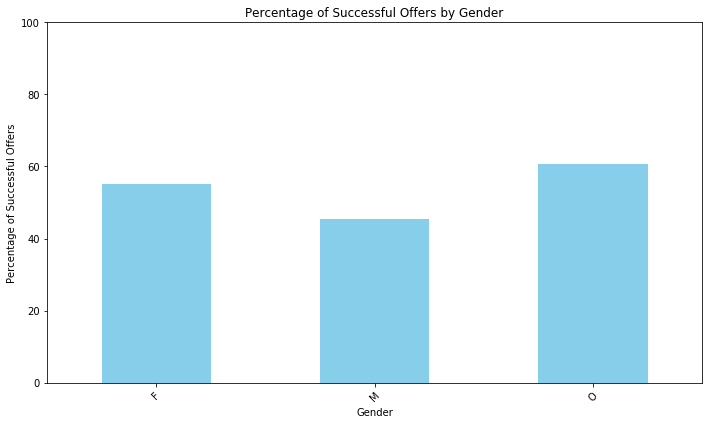

In [101]:
#plot successful offers by gender
plot_successful_offers_by_metric(customer_transaction_offer_data_2, 'gender')

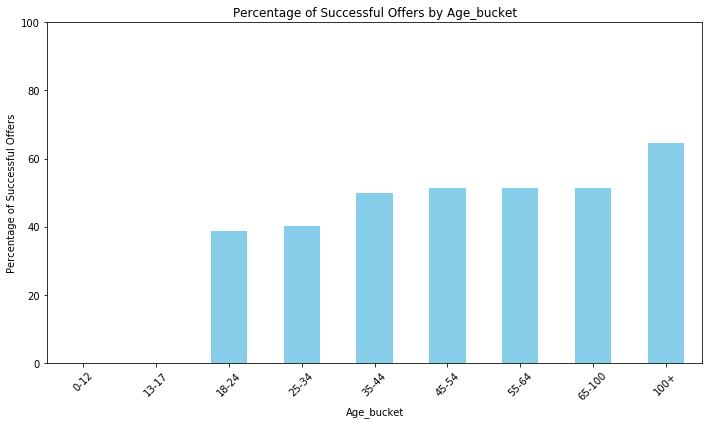

In [102]:
#plot successful offers by age bucket
plot_successful_offers_by_metric(customer_transaction_offer_data_2, 'age_bucket')

## Clustering Analysis

We have now explored our data. We are going to cluster the customers into groups, which we will then use to help to decide who to send offers to. 

In [103]:
#calculate average transaction value
customer_transaction_offer_data_2['avg_transaction_value'] = (customer_transaction_offer_data_2['total_spent']/customer_transaction_offer_data_2['num_of_transactions']).fillna(0)

In [104]:
customer_transaction_offer_data_2['gender'].unique()

array(['M', 'O', 'F'], dtype=object)

In [105]:
#one hot encode the gender and age bucket columns
customer_transaction_offer_data_2  = pd.get_dummies(customer_transaction_offer_data_2, columns=['gender', 'age_bucket'])

In [106]:
customer_transaction_offer_data_2.head()

,person,num_of_bogo_offers_received,num_of_discount_offers_received,num_of_informational_offers_received,num_of_bogo_offers_viewed,num_of_discount_offers_viewed,num_of_informational_offers_viewed,num_of_bogo_offers_completed,num_of_discount_offers_completed,num_of_offers_received,...,gender_O,age_bucket_0-12,age_bucket_13-17,age_bucket_18-24,age_bucket_25-34,age_bucket_35-44,age_bucket_45-54,age_bucket_55-64,age_bucket_65-100,age_bucket_100+
0,0009655768c64bdeb2e877511632db8f,1,2,2,1.0,1.0,2.0,1.0,2.0,5,...,0,0,0,0,1,0,0,0,0,0
2,0011e0d4e6b944f998e987f904e8c1e5,1,2,2,1.0,2.0,2.0,1.0,2.0,5,...,1,0,0,0,0,1,0,0,0,0
3,0020c2b971eb4e9188eac86d93036a77,2,2,1,1.0,1.0,1.0,1.0,2.0,5,...,0,0,0,0,0,0,0,1,0,0
4,0020ccbbb6d84e358d3414a3ff76cffd,2,1,1,2.0,1.0,1.0,2.0,1.0,4,...,0,0,0,0,1,0,0,0,0,0
5,003d66b6608740288d6cc97a6903f4f0,0,3,2,0.0,2.0,2.0,0.0,3.0,5,...,0,0,0,0,1,0,0,0,0,0


In [107]:
def create_percent_of_offers_columns(df, type_of_offer):
    '''
    Function to create percent of offers viewed and sucessful columns.
    
    Parameters: 
        df: dataframe containing offers_viewed and offers_succesful columns by type_of_offer
        type_of_offer: name of offer
    Output: 
        df: dataframe, containing offers viewed and successful % columns by offer type
    '''
    df[f'%_of_{type_of_offer}_offers_viewed'] = 100*(df[f'num_of_{type_of_offer}_offers_viewed']/df[f'num_of_{type_of_offer}_offers_received']).fillna(0)
    df[f'%_of_{type_of_offer}_offers_successful'] = 100*(df[f'num_of_{type_of_offer}_offers_successful']/df[f'num_of_{type_of_offer}_offers_received']).fillna(0)
    return df

In [108]:
#create percent_of_offers columns for bogo, discount and informational offesr

customer_transaction_offer_data_2 = create_percent_of_offers_columns(customer_transaction_offer_data_2, 'bogo')
customer_transaction_offer_data_2 = create_percent_of_offers_columns(customer_transaction_offer_data_2, 'discount')
customer_transaction_offer_data_2 = create_percent_of_offers_columns(customer_transaction_offer_data_2, 'informational')

In [109]:
customer_transaction_offer_data_2.head()

,person,num_of_bogo_offers_received,num_of_discount_offers_received,num_of_informational_offers_received,num_of_bogo_offers_viewed,num_of_discount_offers_viewed,num_of_informational_offers_viewed,num_of_bogo_offers_completed,num_of_discount_offers_completed,num_of_offers_received,...,age_bucket_45-54,age_bucket_55-64,age_bucket_65-100,age_bucket_100+,%_of_bogo_offers_viewed,%_of_bogo_offers_successful,%_of_discount_offers_viewed,%_of_discount_offers_successful,%_of_informational_offers_viewed,%_of_informational_offers_successful
0,0009655768c64bdeb2e877511632db8f,1,2,2,1.0,1.0,2.0,1.0,2.0,5,...,0,0,0,0,100.0,100.0,50.000000,50.000000,100.0,100.0
2,0011e0d4e6b944f998e987f904e8c1e5,1,2,2,1.0,2.0,2.0,1.0,2.0,5,...,0,0,0,0,100.0,100.0,100.000000,100.000000,100.0,0.0
3,0020c2b971eb4e9188eac86d93036a77,2,2,1,1.0,1.0,1.0,1.0,2.0,5,...,0,1,0,0,50.0,50.0,50.000000,50.000000,100.0,100.0
4,0020ccbbb6d84e358d3414a3ff76cffd,2,1,1,2.0,1.0,1.0,2.0,1.0,4,...,0,0,0,0,100.0,100.0,100.000000,100.000000,100.0,100.0
5,003d66b6608740288d6cc97a6903f4f0,0,3,2,0.0,2.0,2.0,0.0,3.0,5,...,0,0,0,0,0.0,0.0,66.666667,66.666667,100.0,100.0


In [110]:
#rename columns so we can run the create_percent_of_offers function for total offers viewed and succesful %s
customer_transaction_offer_data_2 = customer_transaction_offer_data_2.rename(columns = {'num_of_successful_offers': 'num_of_total_offers_successful', 'num_of_offers_viewed': 'num_of_total_offers_viewed', 'num_of_offers_received':'num_of_total_offers_received'})

In [111]:
#create percent of offers columns for total
customer_transaction_offer_data_2 = create_percent_of_offers_columns(customer_transaction_offer_data_2, 'total')

In [112]:
customer_transaction_offer_data_2.head()

,person,num_of_bogo_offers_received,num_of_discount_offers_received,num_of_informational_offers_received,num_of_bogo_offers_viewed,num_of_discount_offers_viewed,num_of_informational_offers_viewed,num_of_bogo_offers_completed,num_of_discount_offers_completed,num_of_total_offers_received,...,age_bucket_65-100,age_bucket_100+,%_of_bogo_offers_viewed,%_of_bogo_offers_successful,%_of_discount_offers_viewed,%_of_discount_offers_successful,%_of_informational_offers_viewed,%_of_informational_offers_successful,%_of_total_offers_viewed,%_of_total_offers_successful
0,0009655768c64bdeb2e877511632db8f,1,2,2,1.0,1.0,2.0,1.0,2.0,5,...,0,0,100.0,100.0,50.000000,50.000000,100.0,100.0,80.0,80.0
2,0011e0d4e6b944f998e987f904e8c1e5,1,2,2,1.0,2.0,2.0,1.0,2.0,5,...,0,0,100.0,100.0,100.000000,100.000000,100.0,0.0,100.0,60.0
3,0020c2b971eb4e9188eac86d93036a77,2,2,1,1.0,1.0,1.0,1.0,2.0,5,...,0,0,50.0,50.0,50.000000,50.000000,100.0,100.0,60.0,60.0
4,0020ccbbb6d84e358d3414a3ff76cffd,2,1,1,2.0,1.0,1.0,2.0,1.0,4,...,0,0,100.0,100.0,100.000000,100.000000,100.0,100.0,100.0,100.0
5,003d66b6608740288d6cc97a6903f4f0,0,3,2,0.0,2.0,2.0,0.0,3.0,5,...,0,0,0.0,0.0,66.666667,66.666667,100.0,100.0,80.0,80.0


In [113]:
customer_transaction_offer_data_2.columns

Index(['person', 'num_of_bogo_offers_received',
       'num_of_discount_offers_received',
       'num_of_informational_offers_received', 'num_of_bogo_offers_viewed',
       'num_of_discount_offers_viewed', 'num_of_informational_offers_viewed',
       'num_of_bogo_offers_completed', 'num_of_discount_offers_completed',
       'num_of_total_offers_received', 'num_of_total_offers_viewed',
       'num_of_offers_completed', 'total_spent', 'last_transaction',
       'num_of_transactions', 'age', 'became_member_on', 'id', 'income',
       'membership_duration', 'num_of_bogo_offers_successful',
       'num_of_discount_offers_successful',
       'num_of_informational_offers_successful',
       'num_of_total_offers_successful', 'num_of_unsuccesful_offers',
       'avg_transaction_value', 'gender_F', 'gender_M', 'gender_O',
       'age_bucket_0-12', 'age_bucket_13-17', 'age_bucket_18-24',
       'age_bucket_25-34', 'age_bucket_35-44', 'age_bucket_45-54',
       'age_bucket_55-64', 'age_bucket_65-1

In [114]:
#create a df that we will use for the clustering analysis
features_for_clustering = customer_transaction_offer_data_2[['total_spent','num_of_transactions'
                                                            ] + [col for col in customer_transaction_offer_data_2.columns if col.startswith('%_of_total')
                                                                or col.startswith('num_of_total')]]
                                                            

In [115]:
#analyse null values in features_for_clustering df
features_for_clustering.isna().sum()

total_spent                       0
num_of_transactions               0
num_of_total_offers_received      0
num_of_total_offers_viewed        0
num_of_total_offers_successful    0
%_of_total_offers_viewed          0
%_of_total_offers_successful      0
dtype: int64

In [116]:
#scale data for clustering
scaler = StandardScaler()
features_for_clustering_scaled = scaler.fit_transform(features_for_clustering)

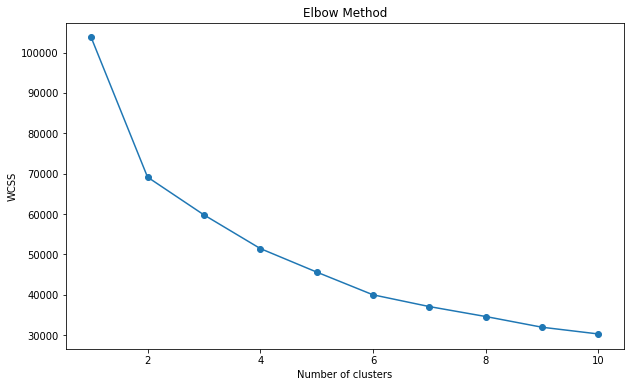

In [117]:
#perform clustering testing to test best number of clusters

#create within cluster sum of squares list 
wcss = []  
#loop through 1-10 clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++',random_state=42)
    kmeans.fit(features_for_clustering_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [118]:
#use the silhouette score to test best number of clusters 
# Initialize list for silhouette score values 
sil_score = []
# Generate silhouette scores for 2 - 10 custers 
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_for_clustering_scaled)
    sil_score.append(silhouette_score(features_for_clustering_scaled, kmeans.labels_))

In [119]:
# Create dataframe with the cluster and silhouette score values 
df_sil = pd.DataFrame({'cluster': range(2, 11), 'sil_score': sil_score})

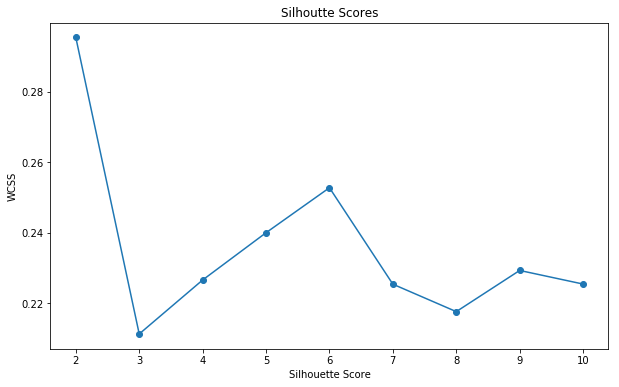

In [120]:
# Plotting the silhouette method
plt.figure(figsize=(10, 6))
plt.plot(df_sil['cluster'], df_sil['sil_score'], marker='o')
plt.title('Silhoutte Scores')
plt.xlabel('Silhouette Score')
plt.ylabel('WCSS')
plt.show()

We note that from the elbow method and the silhouette score, n = 2 clusters appears to the best choice. However from a customer marketing analysis point of view, we decide that we want to split the customers into more segments. The next best choice of n is n = 6, which we will take to be our number of clusters.



In [121]:
#set n = 6 in the k-means clustering model
kmeans = KMeans(n_clusters=6, random_state=42)
#fit and predict cluster numbers for our data
customer_transaction_offer_data_2['cluster'] = kmeans.fit_predict(features_for_clustering_scaled)

In [122]:
customer_transaction_offer_data_2.head()

,person,num_of_bogo_offers_received,num_of_discount_offers_received,num_of_informational_offers_received,num_of_bogo_offers_viewed,num_of_discount_offers_viewed,num_of_informational_offers_viewed,num_of_bogo_offers_completed,num_of_discount_offers_completed,num_of_total_offers_received,...,age_bucket_100+,%_of_bogo_offers_viewed,%_of_bogo_offers_successful,%_of_discount_offers_viewed,%_of_discount_offers_successful,%_of_informational_offers_viewed,%_of_informational_offers_successful,%_of_total_offers_viewed,%_of_total_offers_successful,cluster
0,0009655768c64bdeb2e877511632db8f,1,2,2,1.0,1.0,2.0,1.0,2.0,5,...,0,100.0,100.0,50.000000,50.000000,100.0,100.0,80.0,80.0,2
2,0011e0d4e6b944f998e987f904e8c1e5,1,2,2,1.0,2.0,2.0,1.0,2.0,5,...,0,100.0,100.0,100.000000,100.000000,100.0,0.0,100.0,60.0,2
3,0020c2b971eb4e9188eac86d93036a77,2,2,1,1.0,1.0,1.0,1.0,2.0,5,...,0,50.0,50.0,50.000000,50.000000,100.0,100.0,60.0,60.0,4
4,0020ccbbb6d84e358d3414a3ff76cffd,2,1,1,2.0,1.0,1.0,2.0,1.0,4,...,0,100.0,100.0,100.000000,100.000000,100.0,100.0,100.0,100.0,2
5,003d66b6608740288d6cc97a6903f4f0,0,3,2,0.0,2.0,2.0,0.0,3.0,5,...,0,0.0,0.0,66.666667,66.666667,100.0,100.0,80.0,80.0,4


In [123]:
#calculate cluster means for each cluster and metric
cluster_means = customer_transaction_offer_data_2.groupby('cluster').mean()



In [124]:
#analyse the cluster means for the columns that were used for clustering
cluster_means[[col for col in features_for_clustering.columns]]

,total_spent,num_of_transactions,num_of_total_offers_received,num_of_total_offers_viewed,num_of_total_offers_successful,%_of_total_offers_viewed,%_of_total_offers_successful
cluster,,,,,,,
0,111.294556,7.138545,3.256364,2.922182,2.208727,90.715152,68.351515
1,32.853772,4.343278,4.912894,3.823388,0.835734,78.797439,16.550640
2,174.761670,10.501914,5.096774,4.720339,4.197649,93.074540,83.218061
3,786.629137,10.902878,4.726619,3.848921,3.482014,81.594724,73.950839
4,128.465220,13.997200,4.977200,3.220400,2.444000,65.360000,49.703333
5,56.551277,5.593083,3.980500,1.577263,0.735835,40.814324,18.885823


In [125]:
cluster_means[['total_spent', 'num_of_transactions', '%_of_total_offers_viewed', '%_of_total_offers_successful']]

,total_spent,num_of_transactions,%_of_total_offers_viewed,%_of_total_offers_successful
cluster,,,,
0,111.294556,7.138545,90.715152,68.351515
1,32.853772,4.343278,78.797439,16.550640
2,174.761670,10.501914,93.074540,83.218061
3,786.629137,10.902878,81.594724,73.950839
4,128.465220,13.997200,65.360000,49.703333
5,56.551277,5.593083,40.814324,18.885823


In [126]:
# Create a DataFrame for the cluster centers
cluster_centres_df = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features_for_clustering.columns)

In [127]:
customer_transaction_offer_data_2['cluster'].unique()

array([2, 4, 0, 1, 5, 3])

In [128]:
#create categories, based on the values (High, Medium, Low) of the mean of each cluster
cluster_categories = {
    'Cluster': [0,1,2,3,4,5],
    'Total Spent': ['M' ,'L', 'M', 'H', 'M', 'L'],
    'Number of transactions': ['M', 'L', 'M', 'M','H', 'L'],
    'Offer View %': ['H', 'M','H','M','M','L'],
    'Offer Completion %': ['M','L', 'H', 'H', 'M', 'L']
}

cluster_categories_df = pd.DataFrame(cluster_categories)

In [129]:
# Define a function to apply styles
def highlight_cells(val):
    '''
     Function to conditional format cells in a df
    
    Parameters: 
        val: value
    Output: 
        color: color for the df to be conditionally formatted
    '''
    color = ''
    if val == 'H':
        color = 'background-color: green; color: white;'
    elif val == 'M':
        color = 'background-color: orange; color: white;'
    elif val == 'L':
        color = 'background-color: red; color: white;'
    return color



In [130]:
# Apply the function to the DataFrame
styled_cluster_categories = cluster_categories_df.style.applymap(highlight_cells)
styled_cluster_categories

,Cluster,Total Spent,Number of transactions,Offer View %,Offer Completion %
0,0,M,M,H,M
1,1,L,L,M,L
2,2,M,M,H,H
3,3,H,M,M,H
4,4,M,H,M,M
5,5,L,L,L,L


In [131]:
#name the clusters based on their spending and offer habits
cluster_names = ['Medium spenders', 'Low spender, but curious', 'Offer savvy', 'Big spenders', 'Frequent spenders', 'Low spenders']
cluster_categories_df['Cluster Name'] = cluster_names

In [132]:
# Apply the function to the DataFrame
styled_cluster_categories = cluster_categories_df.style.applymap(highlight_cells)

In [133]:
styled_cluster_categories

,Cluster,Total Spent,Number of transactions,Offer View %,Offer Completion %,Cluster Name
0,0,M,M,H,M,Medium spenders
1,1,L,L,M,L,"Low spender, but curious"
2,2,M,M,H,H,Offer savvy
3,3,H,M,M,H,Big spenders
4,4,M,H,M,M,Frequent spenders
5,5,L,L,L,L,Low spenders


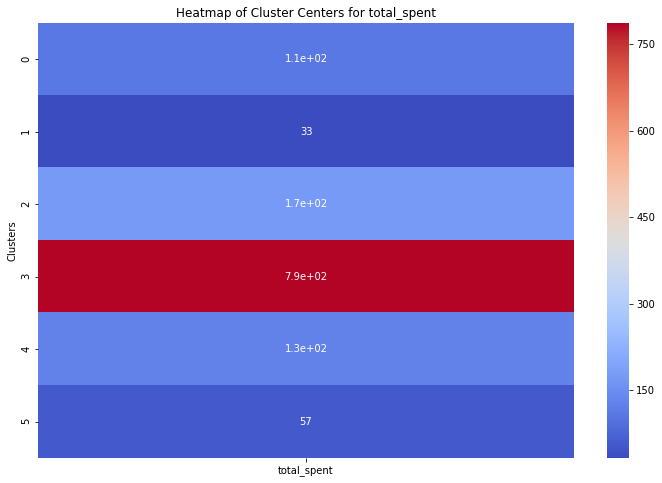

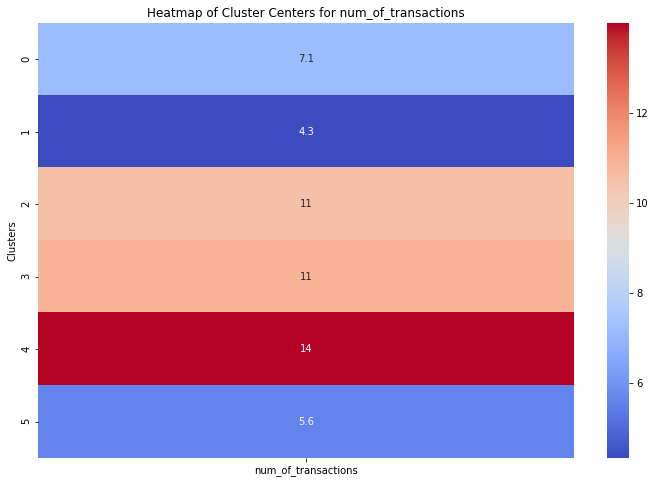

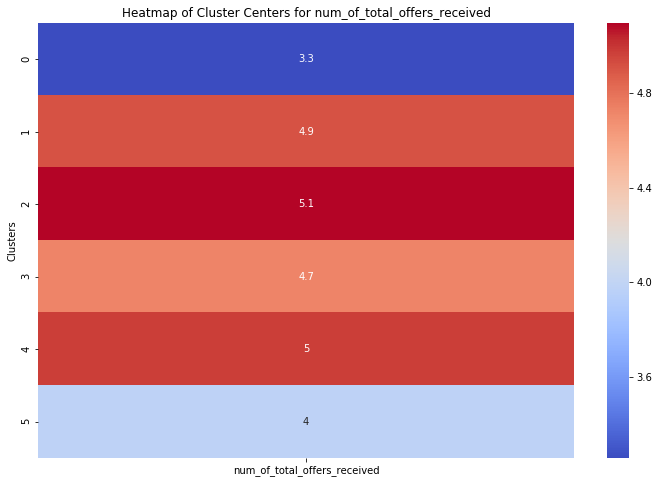

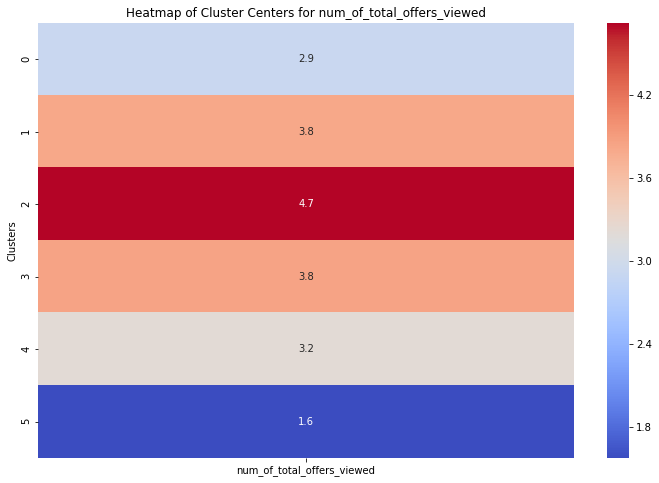

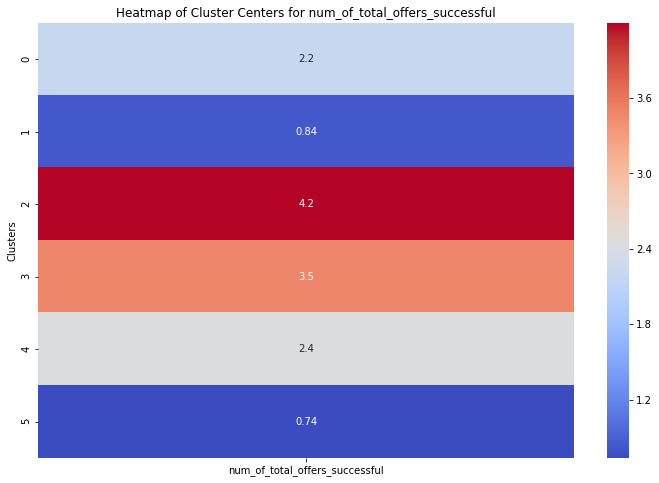

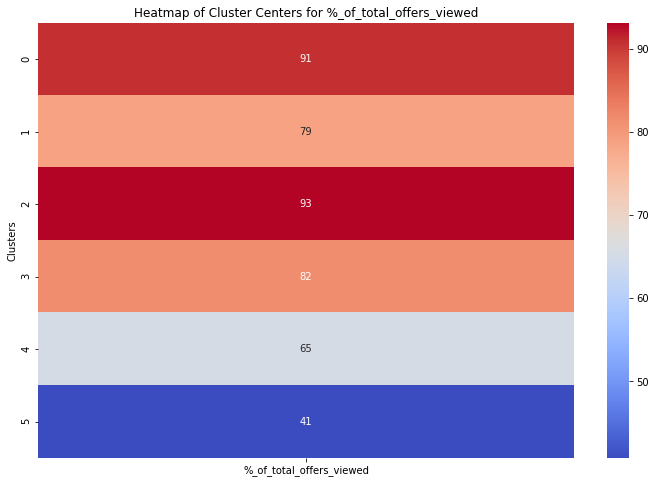

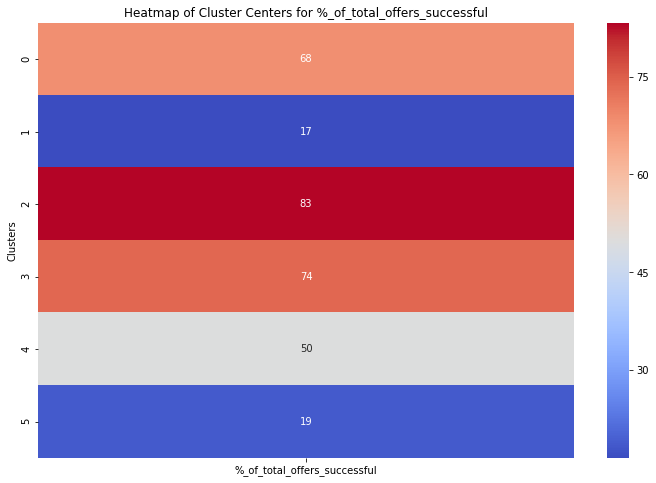

In [134]:
for column in cluster_centres_df.columns:
    # Create a heatmap of the cluster centres
    df_cluster_centre = cluster_centres_df[[column]]
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_cluster_centre, annot=True, cmap='coolwarm')
    plt.title(f'Heatmap of Cluster Centers for {column}')
    #plt.xlabel(f'{col}')
    plt.ylabel('Clusters')
    plt.show()

In [135]:
cluster_centres_df.columns

Index(['total_spent', 'num_of_transactions', 'num_of_total_offers_received',
       'num_of_total_offers_viewed', 'num_of_total_offers_successful',
       '%_of_total_offers_viewed', '%_of_total_offers_successful'],
      dtype='object')

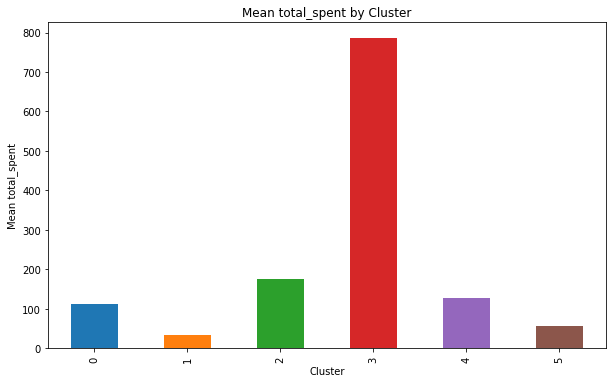

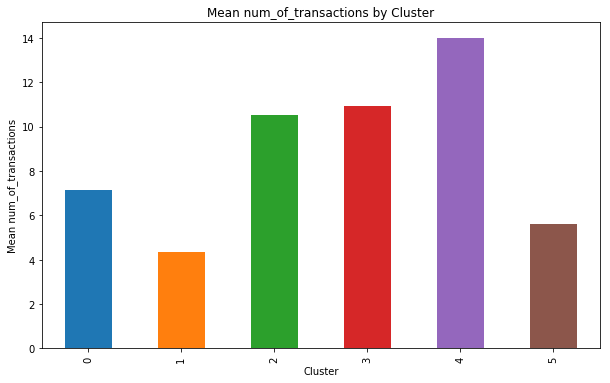

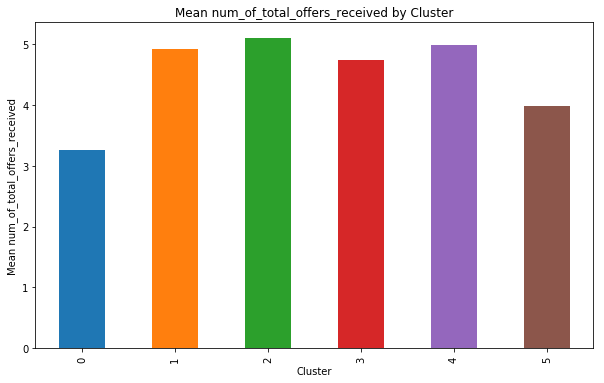

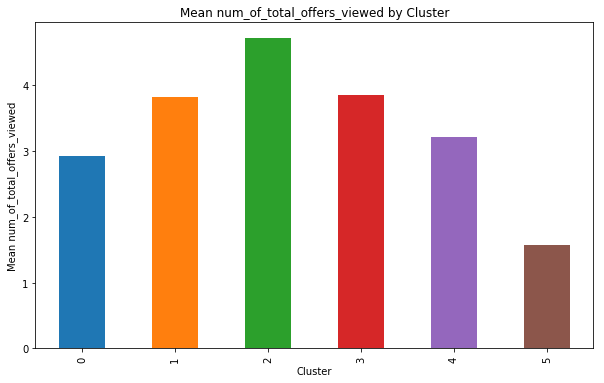

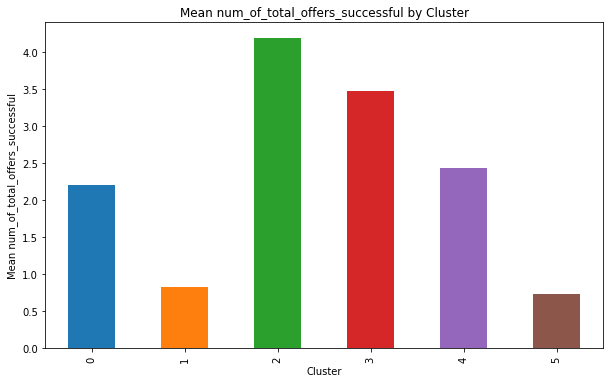

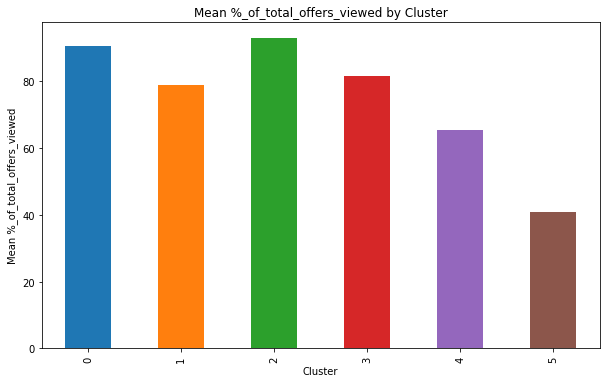

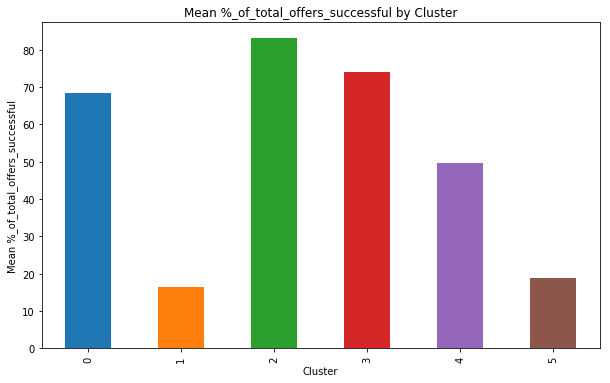

In [136]:
# Plot the mean values of the specific column by cluster
for col in cluster_centres_df.columns:
    plt.figure(figsize=(10, 6))
    customer_transaction_offer_data_2.groupby('cluster')[col].mean().plot(kind='bar')
    plt.title(f'Mean {col} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Mean {col}')
    plt.show()

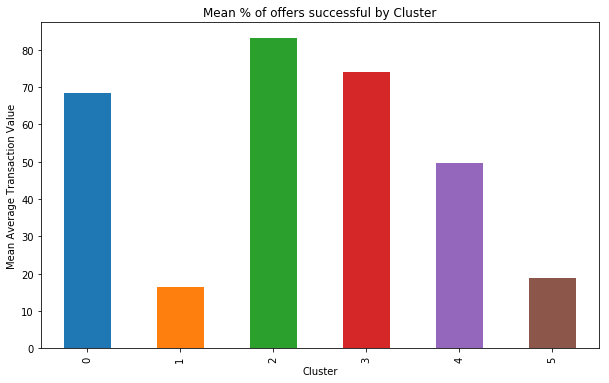

In [137]:
# Plot the mean values of the specific column by cluster
plt.figure(figsize=(10, 6))
customer_transaction_offer_data_2.groupby('cluster')['%_of_total_offers_successful'].mean().plot(kind='bar')
plt.title('Mean % of offers successful by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Average Transaction Value')
plt.show()

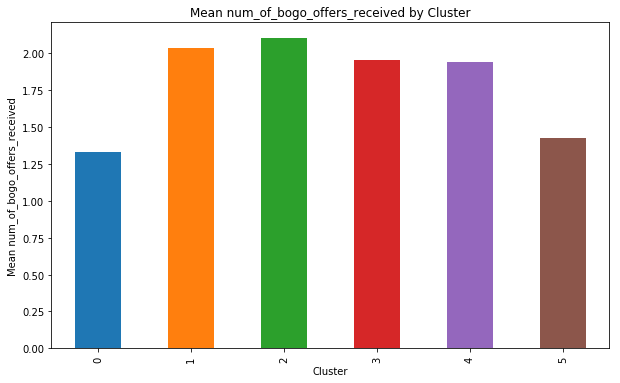

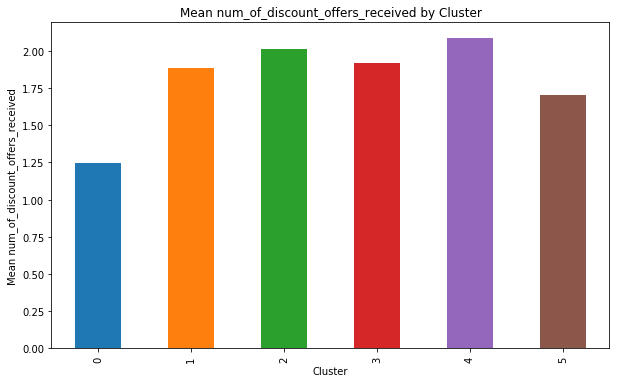

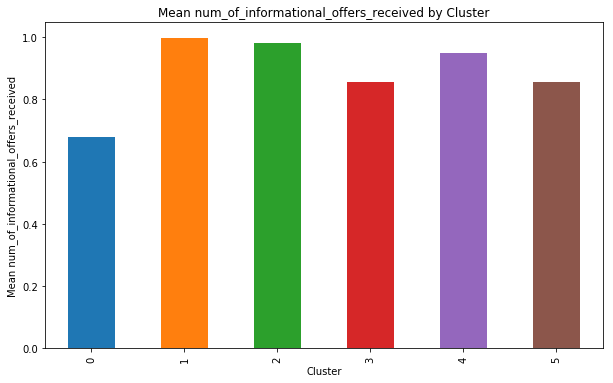

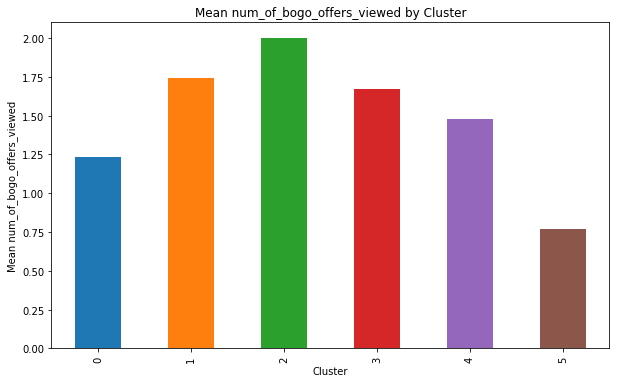

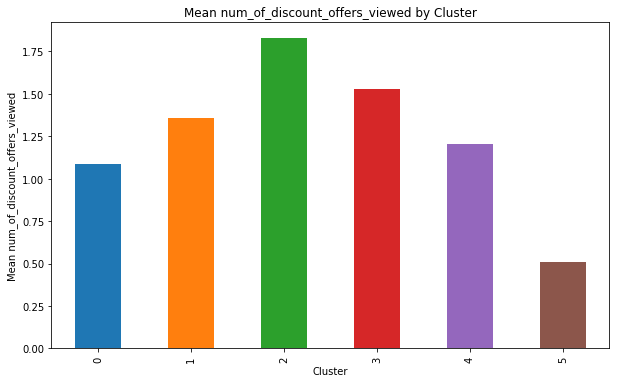

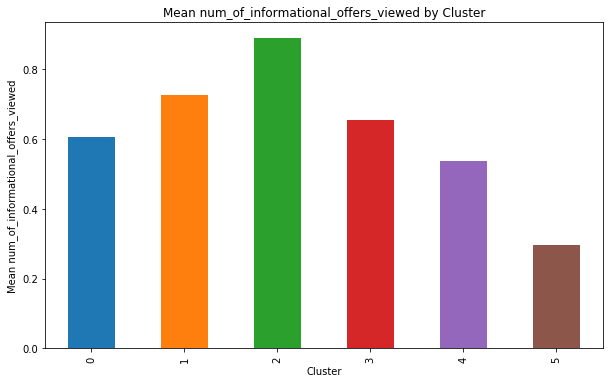

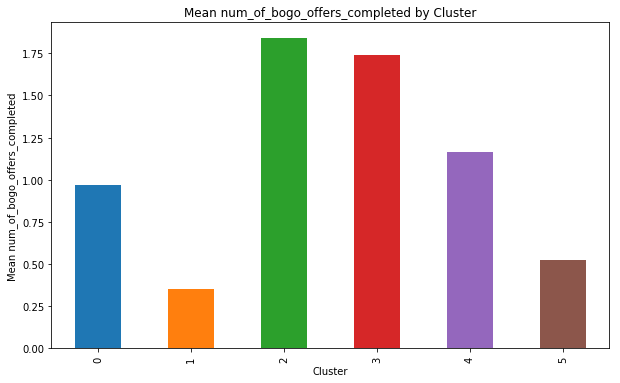

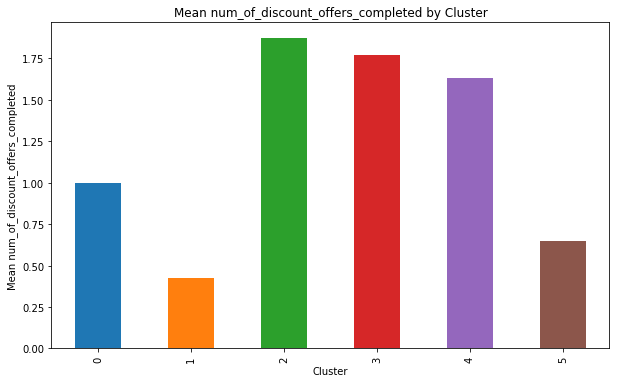

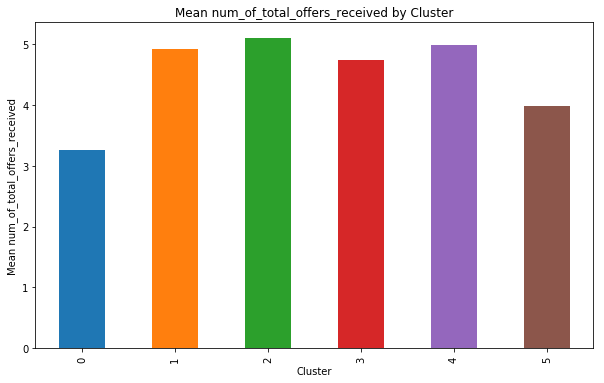

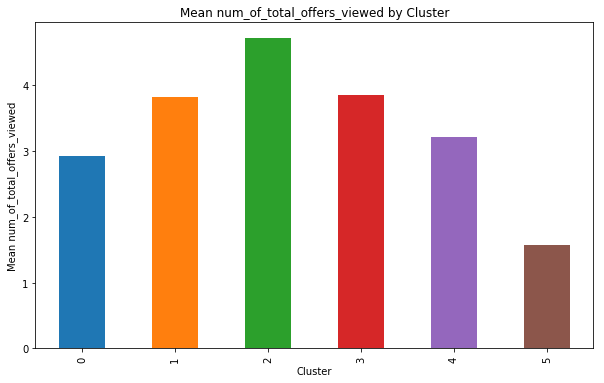

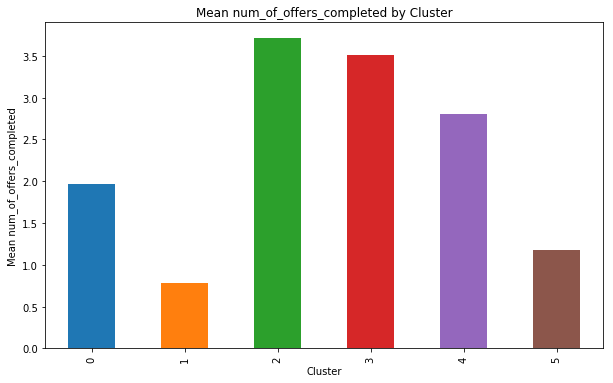

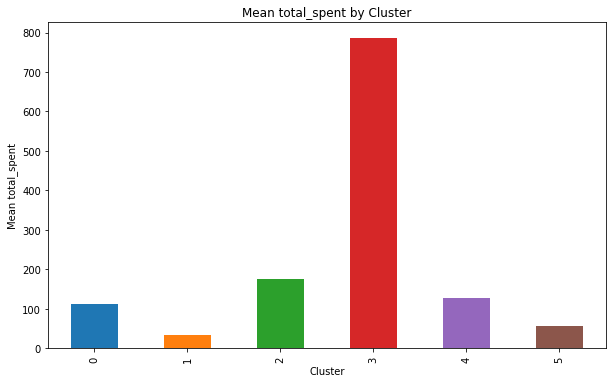

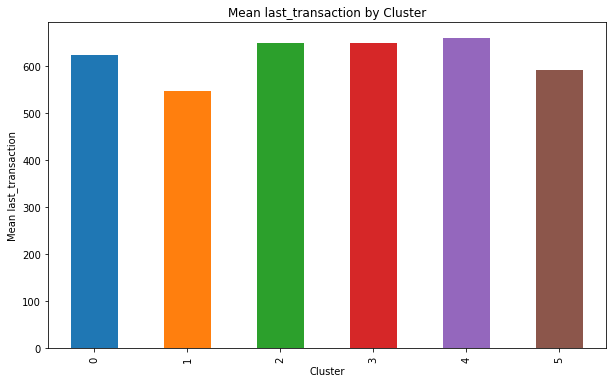

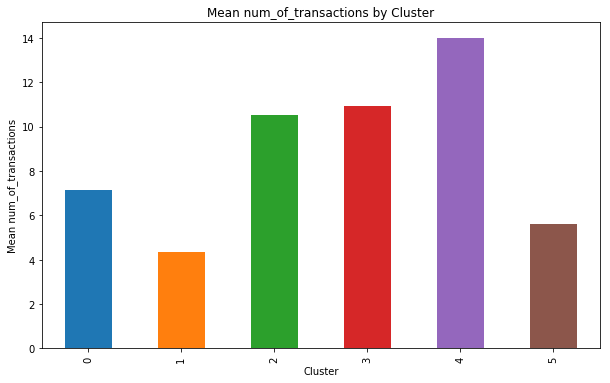

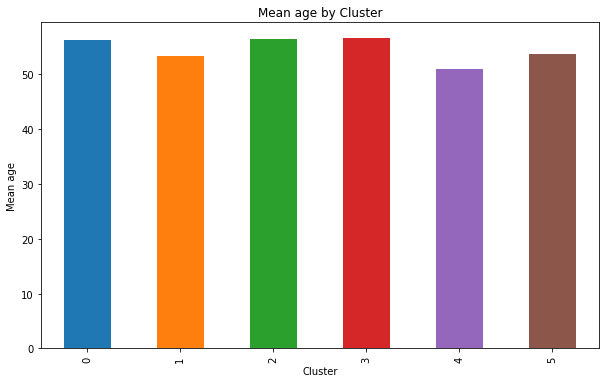

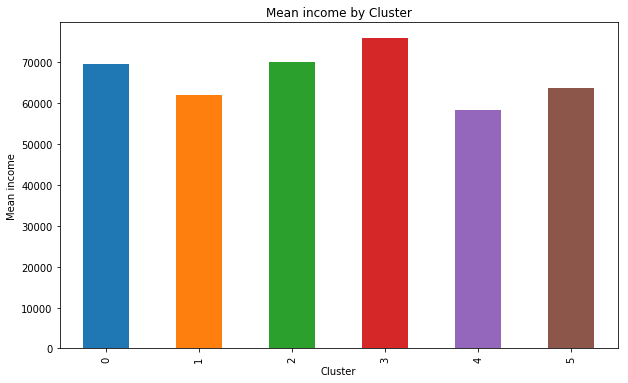

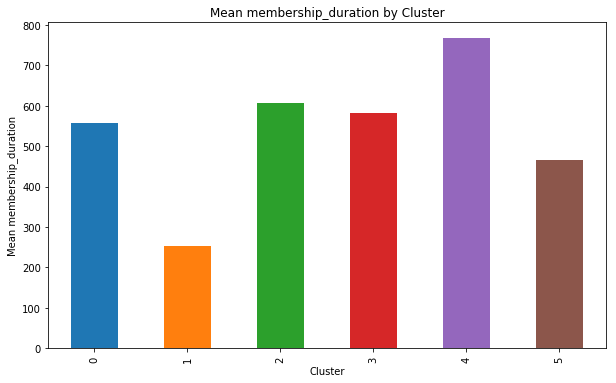

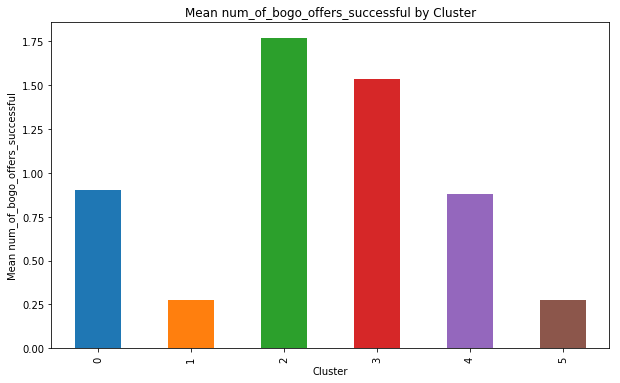

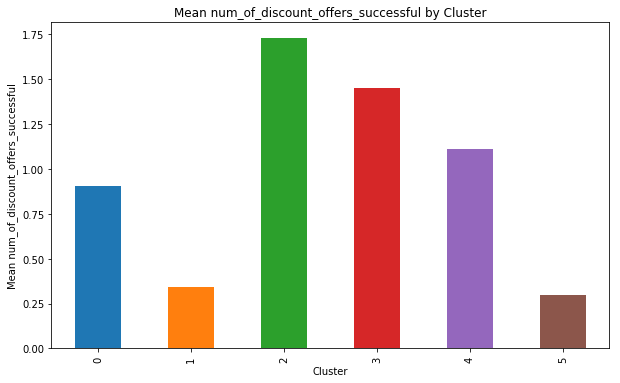

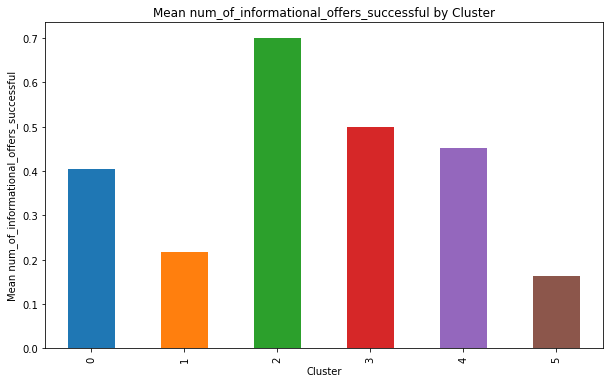

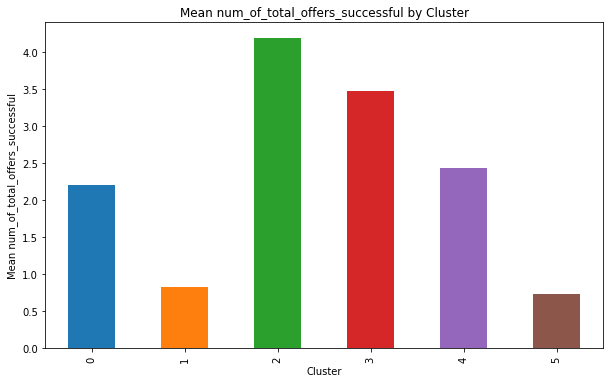

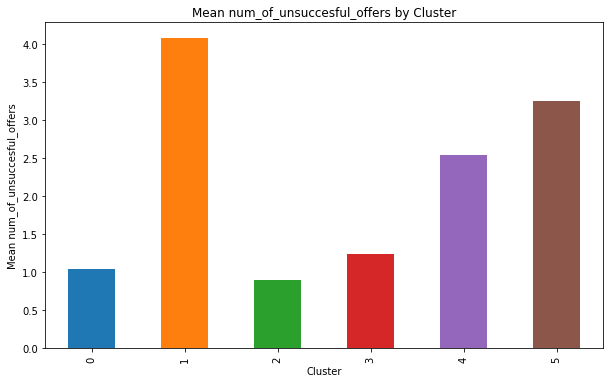

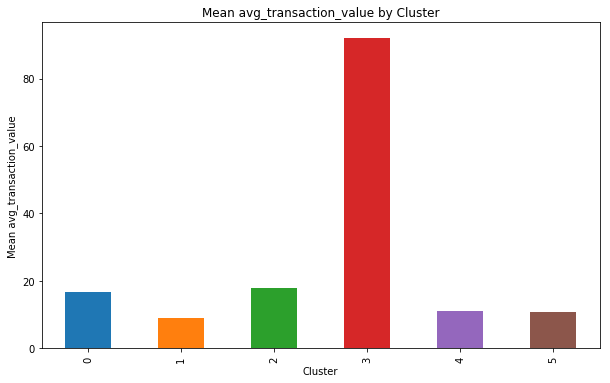

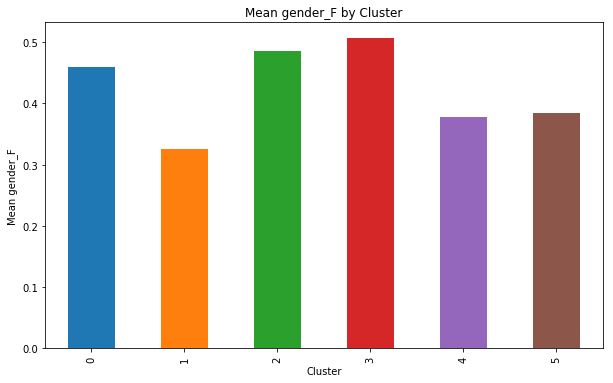

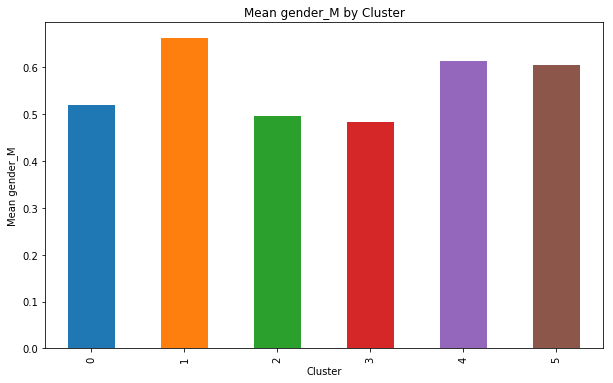

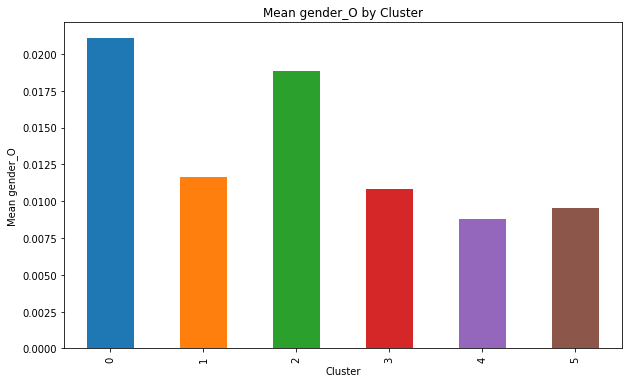

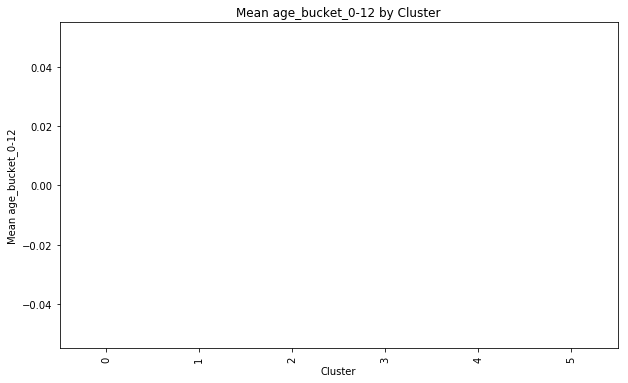

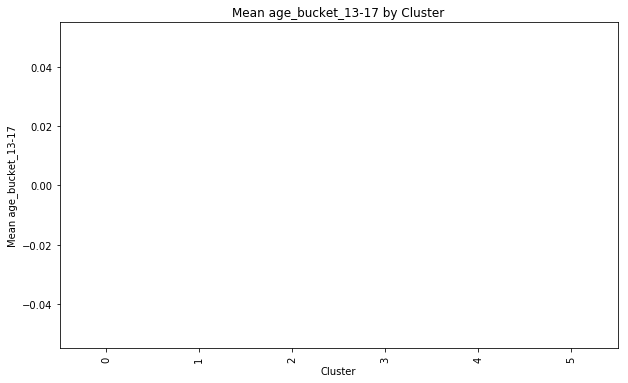

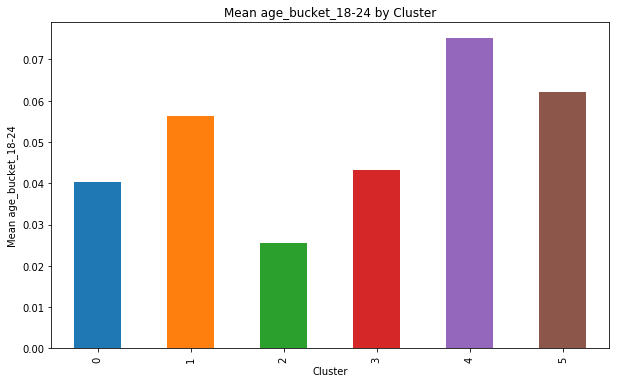

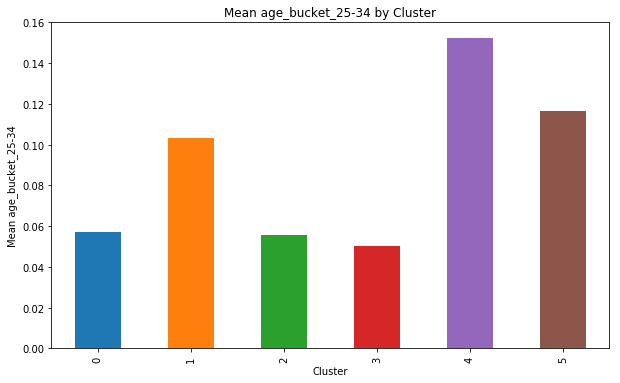

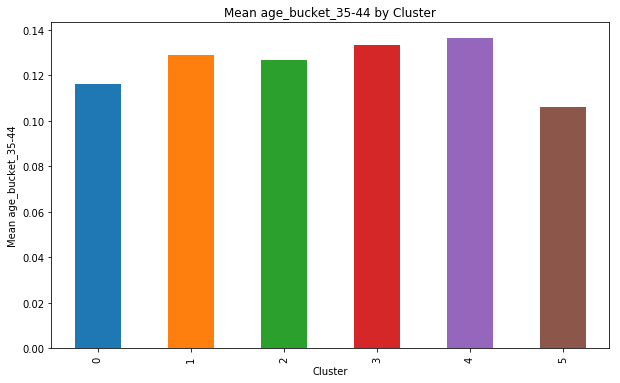

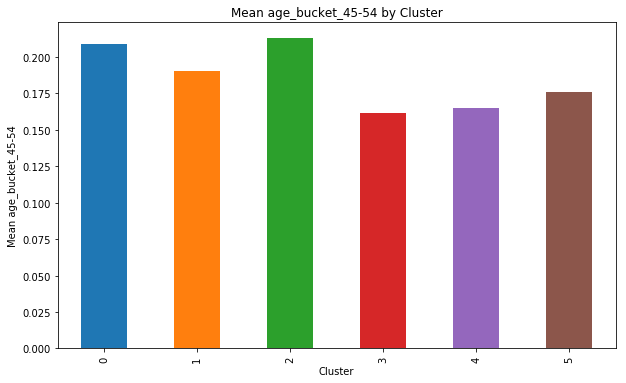

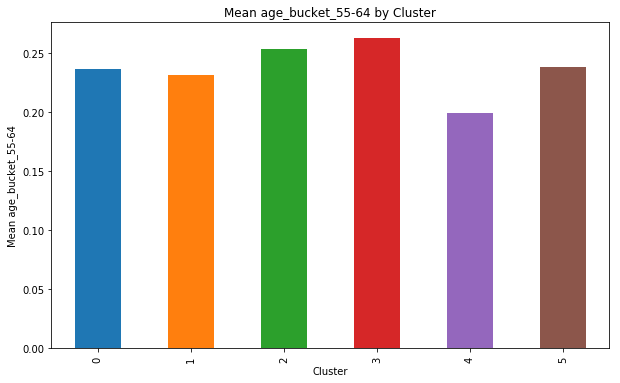

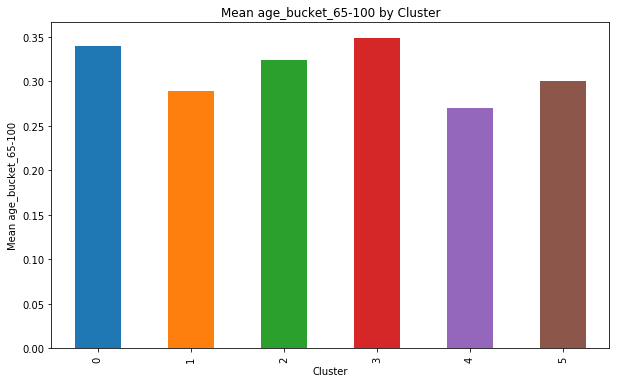

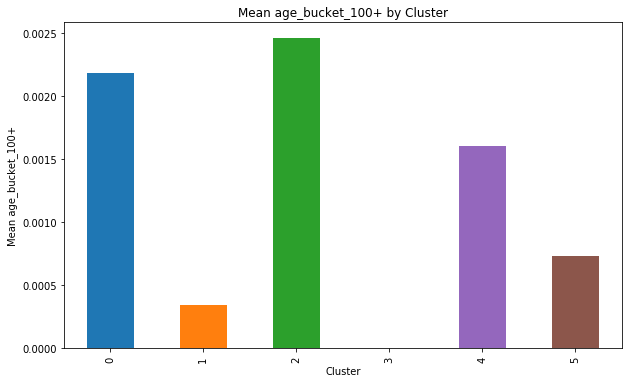

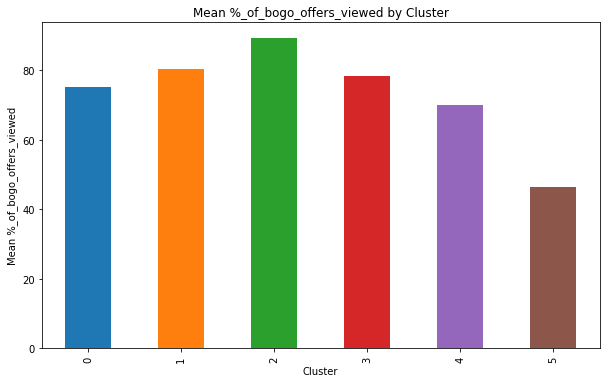

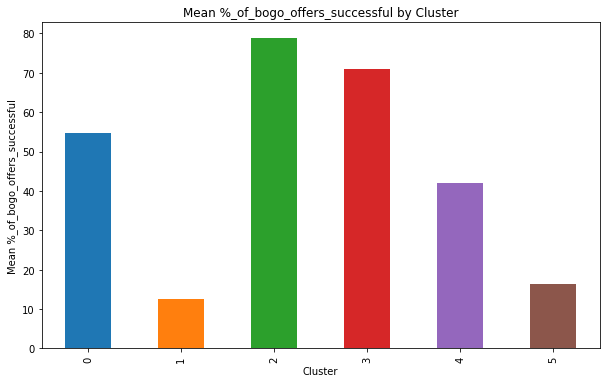

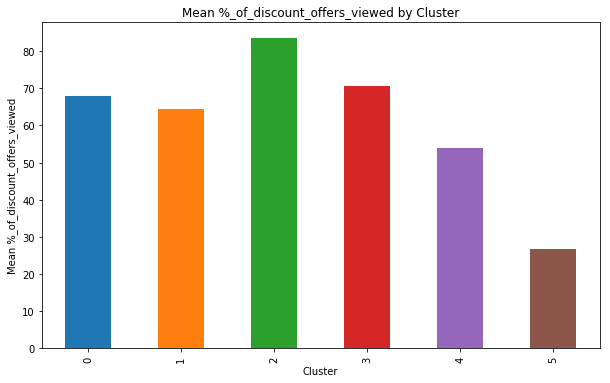

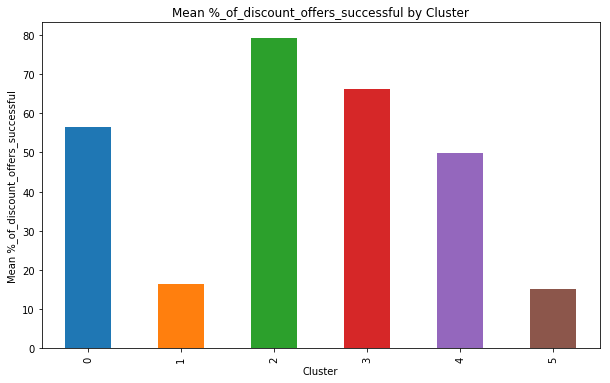

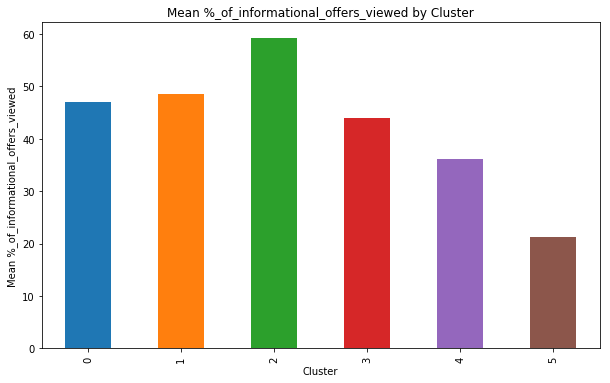

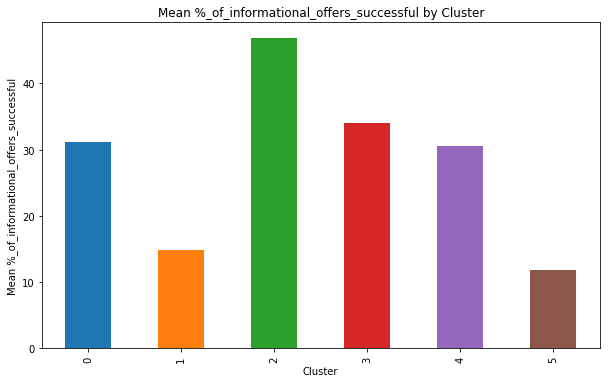

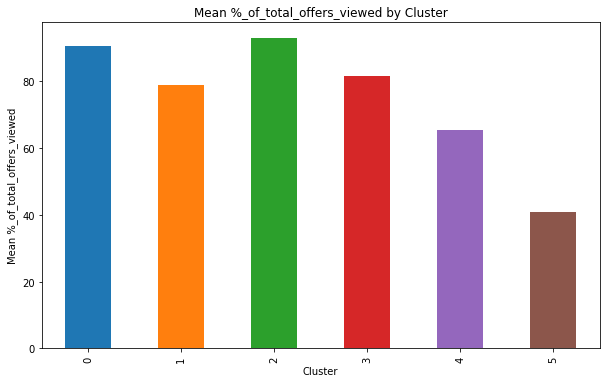

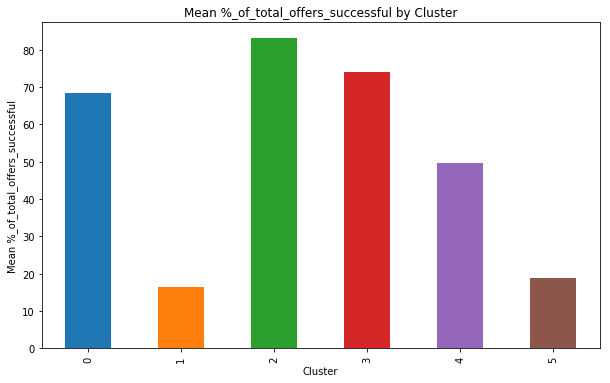

In [138]:
for col in customer_transaction_offer_data_2.groupby('cluster').mean().columns:
    # Plot the mean values of the specific column by cluster
    plt.figure(figsize=(10, 6))
    customer_transaction_offer_data_2.groupby('cluster')[col].mean().plot(kind='bar')
    plt.title(f'Mean {col} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Mean {col}')
    plt.show()

## Offer level predictive model

We are now going to use the clusters that we have created to support the development of a predictive model. The aim of the predictive model will be to predict whether an offer will be successful. 

In [139]:
#create a df with the cluster that each customer is in
customer_clusters = customer_transaction_offer_data_2[['person','cluster']]

In [140]:
customer_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 0 to 16993
Data columns (total 2 columns):
person     14820 non-null object
cluster    14820 non-null int32
dtypes: int32(1), object(1)
memory usage: 289.5+ KB


In [141]:
#check that each person has a unique row in the customer_clusters data (i.e. they have exactly 1 cluster)
customer_clusters['person'].nunique()

14820

In [142]:
#merge the offers_pivot_4 data to the customer cluster dafa
offers_pivot_clustered = pd.merge(offers_pivot_4, customer_clusters, on = 'person', how = 'left')

In [143]:
offers_pivot_clustered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 66500
Data columns (total 20 columns):
offer_id               66501 non-null object
person                 66501 non-null object
offer_idx              66501 non-null int64
offer completed        66501 non-null int64
offer received         66501 non-null int64
offer viewed           66501 non-null int64
channels               66501 non-null object
difficulty             66501 non-null int64
duration               66501 non-null int64
offer_type             66501 non-null object
reward                 66501 non-null int64
successful offer       66501 non-null int64
age                    66501 non-null int64
became_member_on       66501 non-null datetime64[ns]
gender                 66501 non-null object
id                     66501 non-null object
income                 66501 non-null float64
age_bucket             66501 non-null category
membership_duration    66501 non-null int64
cluster                66501 non-nu

In [144]:
#calculate the total number of successful offers
offers_pivot_clustered['successful offer'].mean()

0.49539104675117668

49.5% of offers are successful, so we have a well balanced dataset

In [145]:
offers_pivot_clustered.head()

,offer_id,person,offer_idx,offer completed,offer received,offer viewed,channels,difficulty,duration,offer_type,reward,successful offer,age,became_member_on,gender,id,income,age_bucket,membership_duration,cluster
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,1,1,1,1,"[web, email]",20,10,discount,5,1,40,2018-01-09,O,0011e0d4e6b944f998e987f904e8c1e5,57000.0,35-44,204,2
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,1,1,1,0,"[web, email]",20,10,discount,5,0,26,2017-06-21,F,003d66b6608740288d6cc97a6903f4f0,73000.0,25-34,406,4
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,1,0,1,0,"[web, email]",20,10,discount,5,0,19,2016-08-09,F,00426fe3ffde4c6b9cb9ad6d077a13ea,65000.0,18-24,722,4
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,1,1,1,0,"[web, email]",20,10,discount,5,0,54,2016-08-21,M,0056df74b63b4298809f0b375a304cf4,91000.0,55-64,710,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,00715b6e55c3431cb56ff7307eb19675,1,1,1,1,"[web, email]",20,10,discount,5,1,58,2017-12-07,F,00715b6e55c3431cb56ff7307eb19675,119000.0,55-64,237,4


In [146]:
#one hot encode the gender, age bucket and offer_type columns
offers_pivot_clustered = pd.get_dummies(offers_pivot_clustered,columns=['gender', 'age_bucket', 'offer_type'] )

In [147]:
offers_pivot_clustered.columns

Index(['offer_id', 'person', 'offer_idx', 'offer completed', 'offer received',
       'offer viewed', 'channels', 'difficulty', 'duration', 'reward',
       'successful offer', 'age', 'became_member_on', 'id', 'income',
       'membership_duration', 'cluster', 'gender_F', 'gender_M', 'gender_O',
       'age_bucket_0-12', 'age_bucket_13-17', 'age_bucket_18-24',
       'age_bucket_25-34', 'age_bucket_35-44', 'age_bucket_45-54',
       'age_bucket_55-64', 'age_bucket_65-100', 'age_bucket_100+',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational'],
      dtype='object')

In [148]:
#drop columns that we do not want to include in the predictive model
#we note that we do not want to use any data points that will tell indirectly tell us about the sucess of the offer
# e.g. offer_completed, offer_viewed
offers_pivot_clustered = offers_pivot_clustered.drop(['offer_id', 'person', 'age', 'became_member_on', 'id', 'offer completed', 'offer received', 'offer viewed'],axis = 1)

In [149]:
offers_pivot_clustered.columns

Index(['offer_idx', 'channels', 'difficulty', 'duration', 'reward',
       'successful offer', 'income', 'membership_duration', 'cluster',
       'gender_F', 'gender_M', 'gender_O', 'age_bucket_0-12',
       'age_bucket_13-17', 'age_bucket_18-24', 'age_bucket_25-34',
       'age_bucket_35-44', 'age_bucket_45-54', 'age_bucket_55-64',
       'age_bucket_65-100', 'age_bucket_100+', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational'],
      dtype='object')

In [150]:
#we note that we stil need to expand out the channels columns, we begin by extracting the values from the lists in a long format
channels = offers_pivot_clustered['channels'].apply(pd.Series).stack()

In [151]:
channels.head()

0  0      web
   1    email
1  0      web
   1    email
2  0      web
dtype: object

In [152]:
# Reset index to align with the original DataFrame
channels = channels.reset_index(level=1, drop=True)

In [153]:
channels.head()

0      web
0    email
1      web
1    email
2      web
dtype: object

In [154]:
# One-hot encode the variations
one_hot_encoded = pd.get_dummies(channels, prefix='channel')

# Pivot the one-hot encoded variations back to the original shape
one_hot_encoded_pivoted = one_hot_encoded.groupby(level=0).sum()

In [155]:
# Add the one-hot encoded variations to the original DataFrame
offers_pivot_clustered = pd.concat([offers_pivot_clustered.drop(columns=['channels']), one_hot_encoded_pivoted], axis=1)

In [156]:
offers_pivot_clustered.head()

,offer_idx,difficulty,duration,reward,successful offer,income,membership_duration,cluster,gender_F,gender_M,...,age_bucket_55-64,age_bucket_65-100,age_bucket_100+,offer_type_bogo,offer_type_discount,offer_type_informational,channel_email,channel_mobile,channel_social,channel_web
0,1,20,10,5,1,57000.0,204,2,0,0,...,0,0,0,0,1,0,1,0,0,1
1,1,20,10,5,0,73000.0,406,4,1,0,...,0,0,0,0,1,0,1,0,0,1
2,1,20,10,5,0,65000.0,722,4,1,0,...,0,0,0,0,1,0,1,0,0,1
3,1,20,10,5,0,91000.0,710,0,0,1,...,1,0,0,0,1,0,1,0,0,1
4,1,20,10,5,1,119000.0,237,4,1,0,...,1,0,0,0,1,0,1,0,0,1


In [157]:
offers_pivot_clustered.columns

Index(['offer_idx', 'difficulty', 'duration', 'reward', 'successful offer',
       'income', 'membership_duration', 'cluster', 'gender_F', 'gender_M',
       'gender_O', 'age_bucket_0-12', 'age_bucket_13-17', 'age_bucket_18-24',
       'age_bucket_25-34', 'age_bucket_35-44', 'age_bucket_45-54',
       'age_bucket_55-64', 'age_bucket_65-100', 'age_bucket_100+',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
       'channel_email', 'channel_mobile', 'channel_social', 'channel_web'],
      dtype='object')

In [158]:
#analyse null values in offer_pivot_clustered df 
offers_pivot_clustered.isna().sum()

offer_idx                   0
difficulty                  0
duration                    0
reward                      0
successful offer            0
income                      0
membership_duration         0
cluster                     0
gender_F                    0
gender_M                    0
gender_O                    0
age_bucket_0-12             0
age_bucket_13-17            0
age_bucket_18-24            0
age_bucket_25-34            0
age_bucket_35-44            0
age_bucket_45-54            0
age_bucket_55-64            0
age_bucket_65-100           0
age_bucket_100+             0
offer_type_bogo             0
offer_type_discount         0
offer_type_informational    0
channel_email               0
channel_mobile              0
channel_social              0
channel_web                 0
dtype: int64

Our data has now been prepared, and we can begin the modelling phase

In [159]:
#split the dataset into X and y 
X = offers_pivot_clustered.drop('successful offer', axis = 1)
y = offers_pivot_clustered['successful offer']

In [160]:
#split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [161]:
X_train.head()

,offer_idx,difficulty,duration,reward,income,membership_duration,cluster,gender_F,gender_M,gender_O,...,age_bucket_55-64,age_bucket_65-100,age_bucket_100+,offer_type_bogo,offer_type_discount,offer_type_informational,channel_email,channel_mobile,channel_social,channel_web
58908,1,5,5,5,52000.0,966,2,1,0,0,...,0,0,0,1,0,0,1,1,1,1
19120,1,10,7,2,66000.0,350,5,0,1,0,...,0,0,0,0,1,0,1,1,0,1
28550,1,10,5,10,47000.0,943,2,0,1,0,...,0,1,0,1,0,0,1,1,1,1
33970,1,0,3,0,88000.0,1649,4,0,1,0,...,0,0,0,0,0,1,1,1,1,0
50388,1,10,7,10,89000.0,903,0,0,1,0,...,0,0,0,1,0,0,1,1,1,0


In [162]:
#create pipeline for logistic regression model, scaling the data using StandardScaler and then using LogisticRegression model
pipeline_logistic_regression = Pipeline([
    ('scaler', StandardScaler()),
    ('logregression',LogisticRegression()) 
])

In [163]:
#fit the pipeline on the training data
pipeline_logistic_regression.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [164]:
#predict the y_test values using the log regression pipeline
y_pred_log_regression = pipeline_logistic_regression.predict(X_test)

In [165]:
# Evaluate the model
print(classification_report(y_test, y_pred_log_regression))
print(confusion_matrix(y_test, y_pred_log_regression))
print(accuracy_score(y_test, y_pred_log_regression))

             precision    recall  f1-score   support

          0       0.67      0.67      0.67     10119
          1       0.66      0.66      0.66      9832

avg / total       0.67      0.67      0.67     19951

[[6829 3290]
 [3306 6526]]
0.669390005514


As we have a balanced dataset, we are going to use accuracy as our main evaluation metric. For the logistic regression model we have an accuracy of 66.9%.

In [166]:
#We now create a pipeline using a random forest classifier model
pipeline_rlf = Pipeline([
    ('scaler', StandardScaler()),
    ('rlf', RandomForestClassifier()) 
])

In [167]:
#fit the pipeline on the training data
pipeline_rlf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rlf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
     ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [168]:
#make predictions using the pipeline
y_pred_rlf = pipeline_rlf.predict(X_test)

In [169]:
# Evaluate the model
print(classification_report(y_test, y_pred_rlf))
print(confusion_matrix(y_test, y_pred_rlf))
print(accuracy_score(y_test, y_pred_rlf))

             precision    recall  f1-score   support

          0       0.75      0.79      0.77     10119
          1       0.77      0.73      0.75      9832

avg / total       0.76      0.76      0.76     19951

[[7992 2127]
 [2640 7192]]
0.76106460829


We achieve a 75.8% accuracy using the rlf classifier. 

We now tune the hyperparameters in an effort to improve the accuracy of the model

In [170]:
# Define the parameter grid
param_grid = {
    'rlf__n_estimators': [100, 200, 300],
    'rlf__max_depth': [None, 10, 20, 30],
    'rlf__min_samples_split': [2, 5, 10],
    'rlf__min_samples_leaf': [1, 2, 4]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(pipeline_rlf, param_grid, cv=3
                           , n_jobs=-1, verbose=2)



In [171]:
# Fit the grid search to the data
start = time.time()
grid_search.fit(X_train, y_train)
end = time.time()
elapsed = end-start
print(f"The grid search found the best parameters in {elapsed} seconds")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=2, rlf__n_estimators=100 
[CV] rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=2, rlf__n_estimators=100 
[CV] rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=2, rlf__n_estimators=100 
[CV] rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=2, rlf__n_estimators=200 
[CV] rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=2, rlf__n_estimators=200 
[CV] rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=2, rlf__n_estimators=200 
[CV] rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=2, rlf__n_estimators=300 
[CV] rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=2, rlf__n_estimators=300 
[CV] rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=2, rlf__n_estimators=300 
[CV] rlf__max_depth=None, rlf__min_sa

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.6min


[CV]  rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=5, rlf__n_estimators=200, total= 3.1min
[CV] rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=10, rlf__n_estimators=300 
[CV]  rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=10, rlf__n_estimators=100, total= 1.5min
[CV] rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=10, rlf__n_estimators=300 
[CV] rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=10, rlf__n_estimators=300 
[CV]  rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=10, rlf__n_estimators=100, total= 1.6min
[CV] rlf__max_depth=None, rlf__min_samples_leaf=2, rlf__min_samples_split=2, rlf__n_estimators=100 
[CV]  rlf__max_depth=None, rlf__min_samples_leaf=1, rlf__min_samples_split=5, rlf__n_estimators=200, total= 3.2min
[CV] rlf__max_depth=None, rlf__min_samples_leaf=2, rlf__min_samples_split=2, rlf__n_estimators=100 
[CV]  rlf__max_depth=None, rlf__min

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 26.1min


[CV] rlf__max_depth=10, rlf__min_samples_leaf=4, rlf__min_samples_split=5, rlf__n_estimators=100 
[CV]  rlf__max_depth=10, rlf__min_samples_leaf=2, rlf__min_samples_split=10, rlf__n_estimators=200, total= 2.3min
[CV] rlf__max_depth=10, rlf__min_samples_leaf=4, rlf__min_samples_split=5, rlf__n_estimators=100 
[CV]  rlf__max_depth=10, rlf__min_samples_leaf=4, rlf__min_samples_split=2, rlf__n_estimators=100, total= 1.5min
[CV] rlf__max_depth=10, rlf__min_samples_leaf=4, rlf__min_samples_split=5, rlf__n_estimators=200 
[CV]  rlf__max_depth=10, rlf__min_samples_leaf=2, rlf__min_samples_split=10, rlf__n_estimators=200, total= 2.5min
[CV] rlf__max_depth=10, rlf__min_samples_leaf=4, rlf__min_samples_split=5, rlf__n_estimators=200 
[CV]  rlf__max_depth=10, rlf__min_samples_leaf=2, rlf__min_samples_split=5, rlf__n_estimators=300, total= 3.6min
[CV] rlf__max_depth=10, rlf__min_samples_leaf=4, rlf__min_samples_split=5, rlf__n_estimators=200 
[CV]  rlf__max_depth=10, rlf__min_samples_leaf=2, rlf__m

[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 65.5min finished


The grid search found the best parameters in 3944.480707168579 seconds


In [172]:

print("Best Parameters:", grid_search.best_params_)

# Predict on test dat|a with the best model
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the model
print("Tuned Random Forest")
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))

Best Parameters: {'rlf__max_depth': 10, 'rlf__min_samples_leaf': 4, 'rlf__min_samples_split': 5, 'rlf__n_estimators': 300}
Tuned Random Forest
             precision    recall  f1-score   support

          0       0.80      0.80      0.80     10119
          1       0.79      0.79      0.79      9832

avg / total       0.79      0.79      0.79     19951

[[8057 2062]
 [2039 7793]]
Accuracy: 0.794446393664


With our hyperparameters tuned, we now achieve an accuracy of 79.4%. 

We can use this as our model to predict whether an offer is likely to be succesful.